In [179]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

import matplotlib
from scipy.io import loadmat
import networkx as nx

from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import lsq_linear


import seaborn
import pandas as pd
from sklearn import linear_model
import os
import time

from scipy.linalg import solve_discrete_lyapunov, solve_continuous_lyapunov

import json

from scipy.stats import pearsonr
from scipy.stats import spearmanr
import operator
import regex as re
from scipy.linalg import expm
from networkx.algorithms import bipartite
from networkx.algorithms import components
import random
from scipy.spatial import distance
from scipy.io import savemat
from scipy.stats import ttest_rel

import sys
#youtusys.path.append('/home/michele/karan/final_results/')
import pandas as pd

from controllability_functions import *
#from controllability_functions import *

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

import pingouin as pg


from scipy.linalg import svd
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,mark_inset)

from matplotlib import rc

from scipy.stats import ttest_ind



In [27]:
fpath = './data/'

mat_files = [f for f in sorted_alphanumeric(os.listdir(fpath)) if f.endswith('.mat') and f.startswith('sub') \
             and os.path.isfile(os.path.join(fpath, f))]


nsbj = len(mat_files)

In [28]:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

# Fig 1 

In [29]:
seed_list = list(range(100,110,1))
seed_list

[100, 101, 102, 103, 104, 105, 106, 107, 108, 109]

In [30]:
##################################   RELEVANT CODE   ################################################

In [74]:
nroi=74

if os.path.exists('results/centr_sub_numContr_evalsW.mat'): 
    print('done')
else:
    mat_dict = {}

    for centrality in ["out_degree", "pq", "ratio_degree", "page_rank","modified_pq"]:
        print(centrality)
        all_sub_eval_arr = [] # collection of arr of 23 subjects

        for i in range(len(mat_files)):
            A = loadmat(fpath+mat_files[i])["A_sparse"]
            A = A.T

            num_control_nodes, single_sub_eval_arr = Nodes_eval_relation(A, centrality,acc=np.ones(nroi))
            # single_sub_eval_arr: 74 x 74 matrix, each row represents eigen values at from 
            # highest(ND=74) to lowest(ND=71) num of control nodes

            # here we append the 2x2 matrix in a list
            all_sub_eval_arr.append(single_sub_eval_arr)
        all_sub_eval_arr = np.array(all_sub_eval_arr) # dim: 23x(74x74) 
        mat_dict[centrality] = all_sub_eval_arr

    savemat("/results/centr_sub_numContr_evalsW.mat", mat_dict)

done


In [75]:
seed_list = list(range(100, 100+10, 1))
seed_list

[100, 101, 102, 103, 104, 105, 106, 107, 108, 109]

In [76]:
if os.path.exists('results/Random_sub_numContr_evalsW_fixedSeed.mat'): 
    print('done')
else:

    centrality="random"
    random_dict = {}

    for i in range(len(mat_files)):
        print(mat_files[i][:-4])
    
        single_sub_eval_arr_list = []
    
        A = loadmat(fpath+mat_files[i])["A_sparse"]
        A = A.T

        for j in seed_list:
    
            num_control_nodes, single_sub_eval_arr = Nodes_eval_relation(A, centrality, seed=j,acc=np.ones(nroi))
            #print(num_control_nodes)
            #print(single_sub_eval_arr)
            # single_sub_eval_arr: 74 x 74 matrix, each row represents eigen values at from 
            # highest(ND=74) to lowest(ND=71) num of control nodes
            single_sub_eval_arr_list.append(single_sub_eval_arr)
        random_dict[mat_files[i][:-4]] = np.array(single_sub_eval_arr_list)
    
    #nsbj x 10 x 74 x 74

    savemat("results/Random_sub_numContr_evalsW_fixedSeed.mat", random_dict)

done


In [77]:
def random_stat(path,energy="min"):

    
    subject_names = [mat_files[i][:-4] for i in range(len(mat_files))]

    if energy=="min":
        avg_min_energy_23Sub = []
        std_min_energy_23Sub = []
        max_min_energy_23Sub = []
        min_min_energy_23Sub = []
        
        for i in range(len(subject_names)):
            matrix3d = loadmat(path)[subject_names[i]]

            avg_min_energy_realizations = []
            for j in range(matrix3d.shape[0]):#10 realizations
                avg_min_energy_realizations.append(compute_e_min( list( np.min(matrix3d[j], axis=1) ) ) )
               
            std_min_energy_realizations = np.std(np.array(avg_min_energy_realizations) ,axis=0)
            max_min_energy_realizations = np.max(np.array(avg_min_energy_realizations) ,axis=0)
            min_min_energy_realizations = np.min(np.array(avg_min_energy_realizations) ,axis=0)
            avg_min_energy_realizations = np.mean(np.array(avg_min_energy_realizations) ,axis=0) # taking avg over 10 realizations
            
            avg_min_energy_23Sub.append(list(avg_min_energy_realizations))
            std_min_energy_23Sub.append(list(std_min_energy_realizations))
            max_min_energy_23Sub.append(list(max_min_energy_realizations))
            min_min_energy_23Sub.append(list(min_min_energy_realizations))

            
        avg_min_energy_23Sub = np.mean(np.array(avg_min_energy_23Sub),axis=0)
        std_energy = np.mean(np.array(std_min_energy_23Sub),axis=0) #np.std(  np.log10(compute_e_min( np.array(all_minEvals) )) , axis=0)
        max_energy = np.mean(np.array(max_min_energy_23Sub),axis=0) #np.std(  np.log10(compute_e_min( np.array(all_minEvals) )) , axis=0)
        min_energy = np.mean(np.array(min_min_energy_23Sub),axis=0) #np.std(  np.log10(compute_e_min( np.array(all_minEvals) )) , axis=0)

        
        return avg_min_energy_23Sub, std_energy, max_energy, min_energy

        
        
    elif energy=="median":
        all_medianEnergy = []
        avg_medianEnergy_23Sub = []
        
        for i in range(len(subject_names)):
            matrix3d = loadmat(path)[subject_names[i]]

            avg_medianEnergy_realizations = []
            
            for j in range(matrix3d.shape[0]):#10 realizations
                avg_medianEnergy_realizations.append(list(np.median(compute_e_min( matrix3d[j] ), axis=1)))
                all_medianEnergy.append( list(np.median(compute_e_min( matrix3d[j] ), axis=1))  )

            avg_medianEnergy_realizations = np.mean(np.array(avg_medianEnergy_realizations),axis=0) # taking avg over 10 realizations
            avg_medianEnergy_23Sub.append(list(avg_medianEnergy_realizations))
        avg_medianEnergy_23Sub = np.mean(np.array(avg_medianEnergy_23Sub),axis=0)
        std_energy = np.std(  np.log10(np.array(all_medianEnergy) ) , axis=0)
        
        return avg_medianEnergy_23Sub, std_energy

    

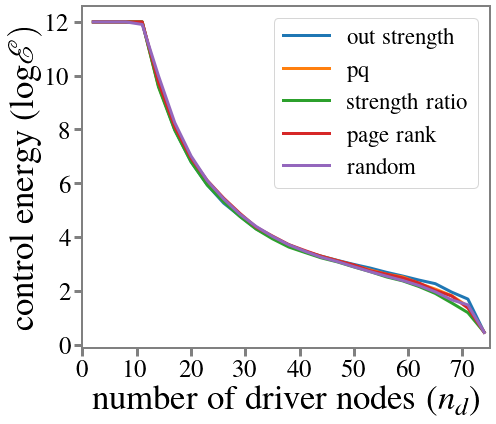

In [41]:
rc('axes',edgecolor='gray',linewidth=2)
nregions=74

Num_control_nodes = np.array(list(range(nregions, 0, -1)))

energy_type="min"

#fig, ax1=plt.figure(figsize=(12,7))
fig, ax1 = plt.subplots(figsize=(7,6))
min_ylim = []

rand_evalFile = "results/Random_sub_numContr_evalsW_fixedSeed.mat"
centr_evalFile  = "results/centr_sub_numContr_evalsW.mat"

cent_names = {'out_degree': 'out strength', 'pq': 'pq', 'ratio_degree': 'strength ratio','page_rank': 'page rank','random': 'random'}

for centrality in ['out_degree', 'pq', 'ratio_degree', 'page_rank', 'random']:
    if centrality=="random":
        
        rand_energy, rand_std, max_energy, min_energy = random_stat(path=rand_evalFile,
                                            energy=energy_type)
        ax1.plot(Num_control_nodes[range(0,74,3)], np.log10(rand_energy)[range(0,74,3)], '-',\
                 label=cent_names[centrality],linewidth=3) # marker='o', markeredgecolor='white',markersize=15
        #ax1.fill_between(Num_control_nodes, np.log10(rand_energy)-rand_std, np.log10(rand_energy)+rand_std,alpha=0.5)
        #ax1.fill_between(Num_control_nodes, np.log10(rand_energy-rand_std), np.log10(rand_energy+rand_std),alpha=0.5)
        #ax1.fill_between(Num_control_nodes, np.log10(min_energy), np.log10(max_energy),alpha=0.5)
        min_ylim.append(min(rand_energy))
        
    else:    
        matrix_3d = loadmat(centr_evalFile)[centrality]
        
        nSubjects = np.shape(matrix_3d)[0]
        N = np.shape(matrix_3d)[1]

        energy = []
        for i in range(nSubjects):
            matrix_2d = matrix_3d[i]
            
            if energy_type=="min":    
                min_evals = np.min(matrix_2d, axis=1)
                energy.append( compute_e_min(min_evals) )
            elif energy_type=="median":
                energy.append( np.median(compute_e_min(matrix_2d) , axis=1) )
                #energy.append( np.median(matrix_2d**-1 , axis=1) )

        energy = np.array(energy).T  # 74X76 matrix   
        #print(energy.shape)
        avg_energy = np.median(np.log10(energy), axis=1)
        

        ax1.plot(Num_control_nodes[range(0,74,3)], avg_energy[range(0,74,3)], '-', \
                 label=cent_names[centrality],linewidth=3) #marker='o', markeredgecolor='white', markersize=15
        min_ylim.append(min(avg_energy))
        

ax1.legend(loc="best", prop={"size":23})

#ax1.tick_params(labelsize=18)
#ax1.set_yscale("log")
#ax1.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
#ax1.grid(linestyle='--',alpha=0.8)

ax1.set_xlabel(r"number of driver nodes ($n_d$)", size=35)
ax1.set_ylabel(r"control energy (log$\mathcal{E})$", size=35)
#ax1.set_title("Full controllability", size=25)

#ax1.set_yscale('log')

ax1.set_xlim([1,75])
#ax1.set_ylim([10**(min(min_ylim)-0.5*(min(min_ylim))),10**13])
ax1.set_xticks(range(0, 75, 10))
ax1.set_xticklabels(range(0, 75, 10),size=25)
ax1.set_yticks(range(0, 13, 2))
ax1.set_yticklabels(range(0, 13, 2),size=25)
ax1.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

plt.tight_layout()

plt.savefig("./figs/fig1a.png", facecolor="white", bbox_inches="tight")


plt.show()    
    

[ 1  2  3  4  5  9 10 11 12 13 17 18 19 20 21]
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


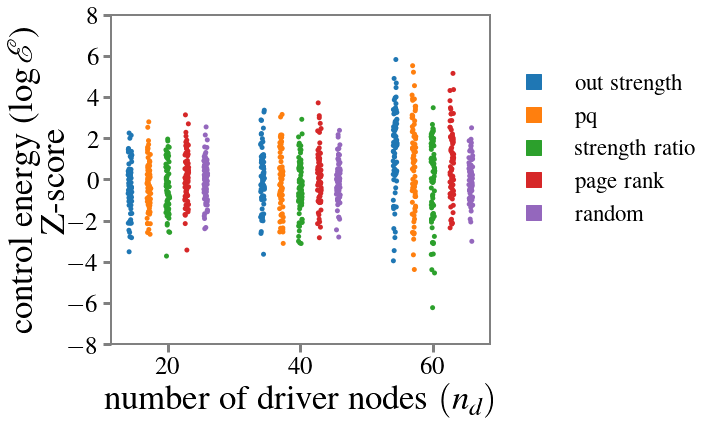

In [51]:
nc = np.asarray([20,40,60])

EG = np.zeros((len(nc),5,76))


rand_evalFile = "results/Random_sub_numContr_evalsW_fixedSeed.mat"
centr_evalFile  = "results/centr_sub_numContr_evalsW.mat"


subject_names = [mat_files[i][:-4] for i in range(len(mat_files))]

a=0;


for centrality in ['out_degree', 'pq', 'ratio_degree', 'page_rank', 'random']:
    
    if centrality=="random":
        path=rand_evalFile
        avg_min_energy_23Sub = []
        
        for i in range(len(subject_names)):
            matrix3d = loadmat(path)[subject_names[i]]

            avg_min_energy_realizations = []
            for j in range(matrix3d.shape[0]):#10 realizations
                avg_min_energy_realizations.append(compute_e_min( list( np.min(matrix3d[j], axis=1) ) ) )
               
            avg_min_energy_realizations = np.mean(np.array(avg_min_energy_realizations) ,axis=0) # taking avg over 10 realizations
            
            avg_min_energy_23Sub.append(list(avg_min_energy_realizations))
                
                
        EG[:,a,:]=(np.matrix(avg_min_energy_23Sub)[:,74-nc]).T
        a=a+1     
        
                
    else:    
        matrix_3d = loadmat(centr_evalFile)[centrality]
        
        nSubjects = np.shape(matrix_3d)[0]
        N = np.shape(matrix_3d)[1]

        energy = []
        for i in range(nSubjects):
            matrix_2d = matrix_3d[i]
            
            min_evals = np.min(matrix_2d, axis=1)
            energy.append( compute_e_min(min_evals) )
           
        energy = np.array(energy).T  # 74X76 matrix   
       
        EG[:,a,:]=energy[74-nc,:]
        a=a+1 


EG=np.log10(EG)
        
for c in range(3):
    EG[c,:,:] = (EG[c,:,:]-np.mean(EG[c,-1,:]))/np.std(EG[c,-1,:])
    
        
base = 0
pos = list(range(1,6))
for q in range(2):
    base = base + 8
    pos = pos + list(range(base+1,base+5+1))

pos = np.array(pos)
print(pos)


fig,ax=plt.subplots(figsize=(10,6))

XX=np.reshape(EG,(3*5,76)).T 

YY=-10*np.ones((76,3*7))

YY[:,0:5]=XX[:,0:5]
YY[:,7:12]=XX[:,5:10]
YY[:,14:19]=XX[:,10:15]


colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

colors7=colors[:7]



#plt.violinplot(XX,colors=colors)



YY=pd.DataFrame(data=np.column_stack((YY.reshape(-1),np.tile(np.arange(21),76),\
    np.tile(np.repeat(np.arange(3),7),76))),columns=['a','b','c'])

#print(XX)

colors = colors * 3


print(colors)


#seaborn.violinplot(data=YY,x="b",y="a",inner='quartile',palette=colors7,width=1.5)

seaborn.stripplot(data=YY,x="b",y="a",palette=colors7,jitter=True)


plt.ylim(-8,8)
plt.xlim(-1,19)

#box=plt.boxplot(np.reshape(EG,(3*5,76)).T,positions=pos,patch_artist=True,showfliers=False)



plt.yticks(size=15)

colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

'''
colors=colors[:5]

colors = colors * 3

for patch,color in zip(box['boxes'],colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

    
for patch in box['medians']:
    patch.set_color('black')
'''

plt.xticks(range(2,20,7),labels=nc,size=25)   
plt.xlabel(r'number of driver nodes $(n_d)$',size=35)
plt.ylabel(r'control energy ($\log\mathcal{E}$)\\ \  ${}_{} \qquad \quad $\ Z-score',size=35)
#plt.ylabel(r'control energy ($\log\mathcal{E}$) \n  Z-score',size=35)
plt.yticks(size=25)   

ax.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)


f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(5)]
labels = cent_names.values()
legend = plt.legend(handles, labels, markerscale=2.5, prop={'size': 23},loc=3, framealpha=1, frameon=False,bbox_to_anchor=(1,0.3))


plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

    
#plt.ylabel(r'$\log_{10}(\mathcal{E})/n_t$',size=25)
    
plt.tight_layout()
plt.savefig("./figs/fig1b.png", facecolor="white", bbox_inches="tight")

plt.show()    

In [69]:
target_list = list(set(range(1,74+1, 1))) #- set(control_nodes))

In [59]:
use_target_as_control=True
use_sbj1= 0
use_sbj2= 76
use_ctr = 5

target_list = list(set(range(1,74+1, 1))) #- set(control_nodes))
seed = 123
np.random.seed(seed)
np.random.shuffle(target_list)


#target_list = target_list[:30]

#target_list = (list(sorted_d0.keys()))

#target_list = nodes_limbic

emin = {}


if os.path.exists('results/target_size.mat'): 
    print('done')
    
else:
    for centrality in ["out_degree", "ratio_degree", "pq", "page_rank"]:
        all_emin_array = []# 230 lists


        for i in range(use_sbj1,use_sbj2):
            A = loadmat(fpath+mat_files[i])["A_sparse"].T
            N = len(A)



            if centrality=="pq":
                sorted_d = rank_pq(A)
            elif centrality=="out_degree":
                sorted_d = rank_Degree(A,rankorder='decreasing') # A should be orginal matrix
            elif centrality=="ratio_degree":
                sorted_d = rank_weight_OutbyIn_Degree(A)
            elif centrality=="page_rank":
                sorted_d = rank_pageRank(A)    

            control_nodes = list(sorted_d.keys())

            if(use_target_as_control==False):
                for t in target_list:
                    control_nodes.remove(t)

            control_nodes = control_nodes[:use_ctr]

            min_evals_W=[]

            target_list1 = deepcopy(target_list)

            # vary the number of nodes in target list
            while len(target_list1)!=0:  
                #Num_control_nodes.append(len(control_nodes))

                ##for t in target_list1:
                ###    if t in control_nodes:
                ###        control_nodes.remove(t)
                ###control_nodes = control_nodes[:10]


                C = compute_C(N, target_list1)# output target matrix

                # compute B 
                # remember to sort the control nodes before constructing the input matrix B
                B = compute_B(N, sorted(control_nodes) )

                # check Kalman rank    
                d = target_controllability_matrix(A.T, B, C)
                rank_d = np.linalg.matrix_rank(d, tol=1E-50).item(0) # Full rank matrix 
                if rank_d!=len(target_list1):
                    print("rank_d != S for Nd = ",B.shape[1])
                    continue

                # compute W
                W = solve_continuous_lyapunov(A.T, -np.matmul(B, B.T)) 

                W_c = np.matmul(C, np.matmul(W, C.T))

                # compute  e_min if possible
                min_evals_W.append( min(np.linalg.eigvals(W_c)) )

                # delete the control node which has lowest out degree.
                del target_list1[-1]


            all_emin_array.append( compute_e_min(min_evals_W) )

        #avg_emin = np.mean(np.array(all_emin_array), axis=0)

        emin[centrality]=np.array(all_emin_array)




    seed_list = list(range(100,110,1))

    ## random    
    for centrality in ["random"]:
        #all_emin_array = []# 230 lists


        all_min_array = []
        all_max_array = []
        all_mean_array = []
        all_stdp_array = []
        all_stdm_array = []


        for i in range(use_sbj1,use_sbj2):

            sbj_emin_array=[]


            A = loadmat(fpath+mat_files[i])["A_sparse"].T
            N = len(A)

            for seed in seed_list:

                np.random.seed(seed)
                control_nodes = list(range(1,N+1))
                np.random.shuffle(control_nodes)


                if(use_target_as_control==False):
                    for t in target_list:
                        control_nodes.remove(t)

                control_nodes = control_nodes[:use_ctr]

                min_evals_W=[]

                target_list1 = deepcopy(target_list)

                # vary the number of nodes in target list
                while len(target_list1)!=0:  

                    ##for t in target_list1:
                    ##    if t in control_nodes:
                    ##        control_nodes.remove(t)
                    ##control_nodes = control_nodes[:10]

                    #Num_control_nodes.append(len(control_nodes))
                    C = compute_C(N, target_list1)# output target matrix

                    # compute B 
                    # remember to sort the control nodes before constructing the input matrix B
                    B = compute_B(N, sorted(control_nodes) )

                    # check Kalman rank    
                    d = target_controllability_matrix(A.T, B, C)
                    rank_d = np.linalg.matrix_rank(d, tol=1E-50).item(0) # Full rank matrix 
                    if rank_d!=len(target_list1):
                        print("rank_d != S for Nd = ",B.shape[1])
                        continue

                    # compute W
                    W = solve_continuous_lyapunov(A.T, -np.matmul(B, B.T)) 

                    W_c = np.matmul(C, np.matmul(W, C.T))

                    # compute  e_min if possible
                    min_evals_W.append( min(np.linalg.eigvals(W_c)) )

                    # delete the control node which has lowest out degree.
                    del target_list1[-1]


                sbj_emin_array.append(compute_e_min(min_evals_W) )

            sbj_min_array=np.min(np.array(sbj_emin_array), axis=0)
            sbj_max_array=np.max(np.array(sbj_emin_array), axis=0)
            sbj_mean_array=np.mean(np.array(sbj_emin_array), axis=0)
            sbj_stdp_array=np.mean(np.array(sbj_emin_array), axis=0)+np.std(np.array(sbj_emin_array), axis=0)
            sbj_stdm_array=np.mean(np.array(sbj_emin_array), axis=0)-np.std(np.array(sbj_emin_array), axis=0)


            all_min_array.append(sbj_min_array)
            all_max_array.append(sbj_max_array)
            all_mean_array.append(sbj_mean_array)
            all_stdp_array.append(sbj_stdp_array)
            all_stdm_array.append(sbj_stdm_array)


        #avg_emin_min = np.mean(np.array(all_min_array), axis=0)
        #avg_emin_max = np.mean(np.array(all_max_array), axis=0)
        #avg_emin_mean = np.mean(np.array(all_mean_array), axis=0)
        #avg_emin_stdp = np.mean(np.array(all_stdp_array), axis=0)
        #avg_emin_stdm = np.mean(np.array(all_stdm_array), axis=0)


        #emin['random mean']=avg_emin_mean
        #emin['random min']=avg_emin_min
        #emin['random max']=avg_emin_max
        #emin['random mean+std']=avg_emin_stdp
        #emin['random mean-std']=avg_emin_stdm

        emin['random mean']=np.array(all_mean_array)
        emin['random min']=np.array(all_min_array)
        emin['random max']=np.array(all_max_array)
        emin['random mean+std']=np.array(all_stdp_array)
        emin['random mean-std']=np.array(all_stdm_array)


    savemat('results/target_size.mat',emin)


done


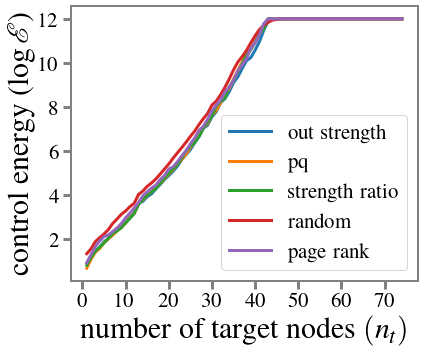

In [94]:
emin=loadmat('results/target_size.mat')

target_list = list(set(range(1,74+1, 1))) #- set(control_nodes))

Num_target_nodes = range(len(target_list), 0, -1 )

plt.figure(figsize=(6,5))
plt.plot(Num_target_nodes,np.log10(np.median(emin['out_degree'],axis=0)),label='out strength',lw=3)
plt.plot(Num_target_nodes,np.log10(np.median(emin['pq'],axis=0)),label='pq',lw=3)
plt.plot(Num_target_nodes,np.log10(np.median(emin['ratio_degree'],axis=0)),label='strength ratio',lw=3)    
plt.plot(Num_target_nodes,np.log10(np.median(emin['random mean'],axis=0)),label='random',lw=3)
plt.plot(Num_target_nodes,np.log10(np.median(emin['page_rank'],axis=0)),label='page rank',lw=3)    
#plt.plot(Num_target_nodes,np.squeeze(emin['out_degree l to h']),label='out degree l to  h',lw=3)

#plt.fill_between(Num_target_nodes,np.squeeze(emin['random max']),np.squeeze(emin['random min']),alpha=0.25)
plt.legend(loc='best',prop={'size': 21})
#plt.yscale('log')
plt.xlabel(r'number of target nodes $(n_t)$',size=30)
plt.ylabel(r"control energy ($\log\mathcal{E}$)",size=30)
plt.xticks(size=21)
plt.yticks(size=21)
plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

#plt.grid()
#plt.xlim(0,15)
#plt.ylim(1,1000)
#plt.xlim(40,55)
#plt.ylim(10**6,10**9)

#plt.show()
plt.tight_layout()

plt.savefig('figs/fig1c.png')
plt.show()


                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
centrality 64.9690 4.0000 300.0000 0.0000

     Contrast    A    B  Paired  Parametric          T   dof alternative  \
0  centrality  0.0  1.0    True        True   0.660540  75.0        less   
1  centrality  0.0  2.0    True        True   0.189752  75.0        less   
2  centrality  0.0  3.0    True        True  -5.952849  75.0        less   
3  centrality  0.0  4.0    True        True -14.682166  75.0        less   
4  centrality  1.0  2.0    True        True  -0.558869  75.0        less   
5  centrality  1.0  3.0    True        True  -5.846038  75.0        less   
6  centrality  1.0  4.0    True        True -11.883480  75.0        less   
7  centrality  2.0  3.0    True        True  -7.313135  75.0        less   
8  centrality  2.0  4.0    True        True -14.758140  75.0        less   
9  centrality  3.0  4.0    True        True  -5.859306  75.0        less   

          p-

/home/michele/.local/lib/python3.9/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/home/michele/.local/lib/python3.9/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
centrality 16.7923 4.0000 300.0000 0.0000

     Contrast    A    B  Paired  Parametric         T   dof alternative  \
0  centrality  0.0  1.0    True        True -2.112531  75.0        less   
1  centrality  0.0  2.0    True        True -2.584982  75.0        less   
2  centrality  0.0  3.0    True        True -3.149862  75.0        less   
3  centrality  0.0  4.0    True        True -8.673658  75.0        less   
4  centrality  1.0  2.0    True        True -0.421972  75.0        less   
5  centrality  1.0  3.0    True        True -1.058205  75.0        less   
6  centrality  1.0  4.0    True        True -6.099519  75.0        less   
7  centrality  2.0  3.0    True        True -0.715559  75.0        less   
8  centrality  2.0  4.0    True        True -5.285549  75.0        less   
9  centrality  3.0  4.0    True        True -5.643983  75.0        less   

          p-unc        

/home/michele/.local/lib/python3.9/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


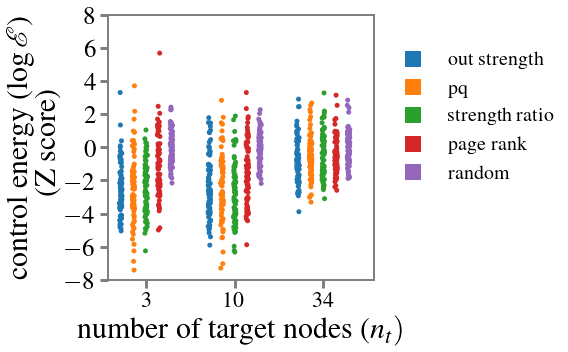

In [62]:
nc = np.asarray([3,10,34])

EG = np.zeros((len(nc),5,76))

a=0;

for centrality in ['out_degree', 'pq', 'ratio_degree', 'page_rank', 'random mean']:
             
    EG[:,a,:]=(emin[centrality][:,74-nc]).T
    a=a+1

EG=np.log10(EG)
        
for c in range(len(nc)):
    EG[c,:,:] = (EG[c,:,:]-np.mean(EG[c,-1,:]))/np.std(EG[c,-1,:])
    
        


for l in range(len(nc)):
        
    eg  = np.zeros((76*5,3))

    c=0

    for k in range(5):
        for n in range(76):
            eg[c,0]=n
            eg[c,1]=k
            eg[c,2]=EG[l,k,n]

            c=c+1

    eg1 = pd.DataFrame(eg,columns = ['subject','centrality','energy'])


    model = AnovaRM(eg1,'energy','subject',within=['centrality'])

        
    res = model.fit()

    print(res)

    pg.rm_anova(dv='energy', within=['centrality'], subject='subject', data=eg1)


    # Optional post-hoc tests
    pht = pg.pairwise_ttests(dv='energy', within=['centrality'], subject='subject', data=eg1,alternative='less',padjust='bonf')

    print(pht)



base = 0
pos = list(range(1,6))
for q in range(2):
    base = base + 8
    pos = pos + list(range(base+1,base+5+1))

pos = np.array(pos)
print(pos)

plt.figure(figsize=(8,5))
      

XX=np.reshape(EG,(3*5,76)).T 

YY=-10*np.ones((76,3*7))
YY[:,0:5]=XX[:,0:5]
YY[:,7:12]=XX[:,5:10]
YY[:,14:19]=XX[:,10:15]

colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
colors7=colors[:7]

YY=pd.DataFrame(data=np.column_stack((YY.reshape(-1),np.tile(np.arange(21),76),\
                                      np.tile(np.repeat(np.arange(3),7),76))),columns=['a','b','c'])

colors7 = colors7 * 3

#seaborn.violinplot(data=YY,x="b",y="a",inner='quartile',palette=colors7,width=1.5)
seaborn.stripplot(data=YY,x="b",y="a",palette=colors7,jitter=True)
 
    
'''  
        
box=plt.boxplot(np.reshape(EG,(3*5,76)).T,positions=pos,patch_artist=True, showfliers=False)
'''

plt.yticks(size=25)

'''
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

colors=colors[:5]

colors = colors * 3

for patch,color in zip(box['boxes'],colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

    
for patch in box['medians']:
    patch.set_color('black')
'''

plt.xlim(-1,20)
plt.ylim(-8,8)
plt.xticks(range(2,20,7),labels=nc,size=22)   
plt.xlabel(r'number of target nodes ($n_t)$',size=30)
plt.ylabel(r'control energy ($\log\mathcal{E}$) \\ ${}_{}\quad\qquad$ (Z score)',size=30)

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(5)]
labels = cent_names.values()
legend = plt.legend(handles, labels, markerscale=2.5, prop={'size': 20},loc=3, framealpha=1, frameon=False,bbox_to_anchor=(1,0.3))

#plt.ylabel(r'$\log_{10}(\mathcal{E})/n_t$',size=25)
plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

    
plt.tight_layout()
plt.savefig("figs/fig1d.png" % {"et": energy_type}, facecolor="white", bbox_inches="tight")

plt.show()    



In [64]:
df_region = pd.read_csv("data/regionclustinfo4.txt", sep=" ", header=None)
nodes = df_region[0].tolist()
regions = df_region[2].tolist()
region_dict = dict(zip(nodes, regions) )
region_list = list(np.unique(np.array(list(region_dict.values()))))


In [67]:

use_target_as_control=False
use_sbj1= 0
use_sbj2= 76
use_ctr = 10

target_list = list(set(range(1,74+1, 1))) #- set(control_nodes))
seed = 123
np.random.seed(seed)

#target_list = target_list[:30]

#target_list = (list(sorted_d0.keys()))

#target_list = nodes_limbic

emin_net = {}

df_region = pd.read_csv("data/regionclustinfo4.txt", sep=" ", header=None)
nodes = df_region[0].tolist()
regions = df_region[2].tolist()
region_dict = dict(zip(nodes, regions) )
region_list = list(np.unique(np.array(list(region_dict.values()))))


if os.path.exists('results/emin_net.mat'): 
    print('done')
    
else:
    for region_name in region_list:
        print(region_name)

        all_emin_array = []# 230 lists


        for i in range(use_sbj1,use_sbj2):

            A = loadmat(fpath+mat_files[i])["A_sparse"].T
            N = len(A)

            target_list = target_nodes(region_dict,region_name)


            centrality="out_degree"
            sorted_d = rank_Degree(A,rankorder='decreasing') # A should be orginal matrix


            for ss in range(10):
                control_nodes = list(sorted_d.keys())

                if(use_target_as_control==False):
                    for t in target_list:
                        control_nodes.remove(t)

                control_nodes = control_nodes[:use_ctr]

                min_evals_W=[]

                target_list1 = deepcopy(target_list)
                np.random.shuffle(target_list1)

                while len(target_list1)!=0:  

                    C = compute_C(N, target_list1)# output target matrix

                    B = compute_B(N, sorted(control_nodes) )

                    d = target_controllability_matrix(A.T, B, C)
                    rank_d = np.linalg.matrix_rank(d, tol=1E-50).item(0) # Full rank matrix 
                    if rank_d!=len(target_list1):
                        print("rank_d != S for Nd = ",B.shape[1])
                        continue

                    # compute W
                    W = solve_continuous_lyapunov(A.T, -np.matmul(B, B.T)) 

                    W_c = np.matmul(C, np.matmul(W, C.T))

                    # compute  e_min if possible
                    min_evals_W.append( min(np.linalg.eigvals(W_c)) )

                    # delete the control node which has lowest out degree.
                    del target_list1[-1]


                all_emin_array.append( compute_e_min(min_evals_W) )


        #avg_emin = np.mean(np.array(all_emin_array), axis=0)

        emin_net[region_name]=np.array(all_emin_array)

        print(np.shape(emin_net[region_name]))


    savemat('results/emin_net.mat',emin_net)

done


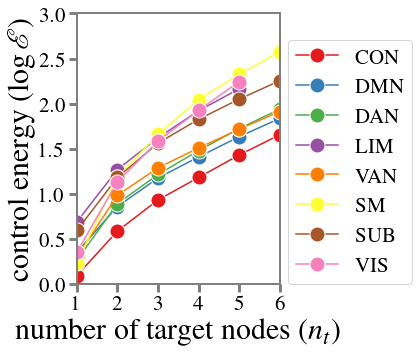

In [68]:
emin_net = loadmat('results/emin_net.mat')

#plt.style.use('seaborn')
region_names_short = ['CON', 'DMN', 'DAN', 'LIM', 'VAN', 'SM','SUB', 'VIS']

cmap = plt.cm.get_cmap('Set1')

plt.figure(figsize=(6,5))
#plt.figure(figsize=(15,10))

c=0
for region_name in region_list:
    target_list = target_nodes(region_dict,region_name)
    Num_target_nodes = range(len(target_list), 0, -1 )
    #print(np.shape(emin_net[region_name]))

    plt.plot(Num_target_nodes,np.mean(np.log10(emin_net[region_name]),axis=0),\
             marker='o', markeredgecolor='white', markersize=15,label=region_names_short[c],c=cmap(c)[:3])
    c=c+1
    
plt.xlim(1,6)
plt.ylim(0,3.0)
plt.xticks(size=21)
plt.yticks(size=21)
plt.xlabel(r'number of target nodes ($n_t$)',size=30)
plt.ylabel(r'control energy ($\log\mathcal{E}$)',size=30)
plt.legend(loc=(1.04, 0),prop={'size': 21})
plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

#plt.grid(linestyle='--',alpha=0.8)
plt.tight_layout()

plt.savefig('figs/fig1e.png')

# Fig 2

In [73]:
def dediag(A):
    return A-np.diag(np.diag(A))

In [78]:
A = np.zeros((nroi,nroi,nsbj))
Ao = np.zeros((nroi,nroi,nsbj))
FC = np.zeros((nroi,nroi,nsbj))

for n in range(nsbj):
    As = loadmat(fpath+mat_files[n])["A_sparse"]
    A[:,:,n]=As.T
    Ao[:,:,n]=dediag(As.T)
    FC[:,:,n] = loadmat(fpath+mat_files[n])["FC"]

In [79]:
Acor=np.zeros((nsbj,nsbj))
Fcor=np.zeros((nsbj,nsbj))

idx0=np.where(np.eye(nroi)>=0)
idx1=np.where(np.triu(np.ones((nroi,nroi)),1)>0)

for n in range(nsbj):
    An=Ao[:,:,n]
    Fn=FC[:,:,n]
    
    for m in range(nsbj):
        Am=Ao[:,:,m]
        Fm=FC[:,:,m]

        Acor[n,m],p=pearsonr(An[idx0],Am[idx0])
        Fcor[n,m],p=pearsonr(Fn[idx1],Fm[idx1])
        
       

idx=np.where(np.triu(np.ones((nsbj,nsbj)),1)>0)

print(np.mean(Acor[idx]))
print(np.std(Acor[idx]))

print(np.mean(Fcor[idx]))
print(np.std(Fcor[idx]))



0.4936520968146068
0.03182416712595814
0.485518179536587
0.07979977960630022


In [80]:
def get_gramian_one(A,i,j):
    B = np.zeros((np.shape(A)[0],1))
    B[i,0]=1
    W=solve_continuous_lyapunov(A.T,-np.matmul(B,B.T))
    #C = np.zeros((1,np.shape(A.T)[0]))
    #C[0,j]=1
        
    #x=np.matmul(np.matmul(C,W),C.T)
    x=W[j,j]
    
    if(np.imag(x)<1.E-10):
        x=np.real(x)
    
    return x     


def get_cont_one(A):
    nroi = np.shape(A)[0]
    Cont = np.zeros((nroi,nroi))
        
    for i in range(nroi):
        for j in range(nroi):
            Cont[i,j]=1./get_gramian_one(A,i,j)
    
    return Cont




In [83]:
if os.path.exists('results/ContMatrix.npy'):
    ContMatrix=np.load('results/ContMatrix.npy')
    print('done')
else:
    ContMatrix = np.zeros((nroi,nroi,nsbj))
    for n in range(nsbj):
        print(n)
        ContMatrix[:,:,n]=get_cont_one(A[:,:,n])
    np.save('results/ContMatrix.npy', ContMatrix)


done


In [85]:
EA_t1 = np.zeros((nroi,nroi,nsbj))
EA_t10 = np.zeros((nroi,nroi,nsbj))

EA_mean = np.zeros((nroi,nroi,nsbj))

if os.path.exists('results/EA.mat'):
    EA=loadmat('results/EA.mat')
    EA_t1=EA['EA_t1']
    EA_t10=EA['EA_t10']
    EA_mean=EA['EA_mean']
    print('done')
else:    
    for n in range(nsbj):
        print(n)
        EA_t1[:,:,n] = expm(A[:,:,n])
        EA_t10[:,:,n] = expm(A[:,:,n]*10)

        EA=np.zeros((nroi,nroi))
    
        for t in np.linspace(0,30,300):
            EA = EA + expm(A[:,:,n]*t)
                
        EA_mean[:,:,n] = EA/300
    
    Edict = {}
    Edict['EA_t1']=EA_t1
    Edict['EA_t10']=EA_t10
    Edict['EA_mean']=EA_mean
    
    savemat('results/EA.mat',Edict)

done


In [86]:
def Asp(A,sign=False,weight='inverse'):
    nroi = np.shape(A)[0]
    if sign==False:
        A=np.abs(A)
    if weight=='inverse':
        A=1./(A+1.E-7)
        
    G=nx.from_numpy_matrix(A,create_using=nx.DiGraph)
    S=np.zeros((nroi,nroi))
    
    for i in range(nroi):
        for j in range(nroi):
            S[i,j]=nx.dijkstra_path_length(G,i,j)
    
    return S


In [87]:
Ashortestpath = np.zeros((nroi,nroi,nsbj))

if os.path.exists('results/Ashortestpath.npy'):
    Ashortestpath=np.load('results/Ashortestpath.npy')
    print('done')
else:
    for n in range(nsbj):
        Ashortestpath[:,:,n]=Asp(A[:,:,n])
        #Ashortestpath[:,:,n,1]=Asp(A[:,:,n],sign=True)
        #Ashortestpath[:,:,n,2]=Asp(A[:,:,n],weight='direct')
        #Ashortestpath[:,:,n,3]=Asp(A[:,:,n],sign=True,weight='direct')
    np.save('results/Ashortestpath.npy',Ashortestpath)


done


In [89]:
def my_scatterplot1(X,Y,idx,xlab,ylab):
    
    sp1=plt.scatter(X[idx],Y[idx],1,c='crimson')

    plt.xlabel(xlab,size=30)
    plt.ylabel(ylab,size=30)

    plt.xticks(size=22)
    plt.yticks(size=22)

    #leg1=plt.legend(handles=sp1,prop={'size': 15},loc='best')
    #ax=plt.gca().add_artist(leg1)
   
    c,p=spearmanr(np.abs(X[idx]),Y[idx])
    #tt="R (%(s1)s,%(s2)s)= %(c)1.2f" % {"c": c} , "s1": xlab, "s2": ylab}
    tt=r"$R$ = %(c)1.2f" % {"c": c}
    sp3=plt.plot([],[],label=tt)

    leg2 = plt.legend(handles=sp3,handlelength=0, handletextpad=0, frameon=False,loc='best',prop={'size': 23})
    plt.tight_layout()
    
    
def my_scatterplot3(X,Y,idx,idx1,idx2,xlab,ylab,xlim1,xlim2):
    
    sp1=plt.scatter(X[idx1],Y[idx1],2,c='crimson')
    sp2=plt.scatter(X[idx2],Y[idx2],2,c=u'#1f77b4')

    plt.xlabel(xlab,size=30)
    plt.ylabel(ylab,size=30)
    plt.xticks(size=22)
    plt.yticks(size=22)

    plt.xlim([xlim1,xlim2])
    #leg1=plt.legend(handles=sp1,prop={'size': 15},loc='best')
    #ax=plt.gca().add_artist(leg1)
   
    c1,p=spearmanr(X[idx1],Y[idx1])
    c2,p=spearmanr(X[idx2],Y[idx2])
    print(c1,c2)
    tt1=r"$R^{(+)}$ = %(c)1.2f" % {"c": c1, "s1": xlab, "s2": ylab}
    sp3=plt.plot([],[],label=tt1)
    tt2=r"$R^{(-)}$ = %(c)1.2f" % {"c": c2, "s1": xlab, "s2": ylab}
    sp4=plt.plot([],[],label=tt2)

    leg2 = plt.legend(handles=sp3,handlelength=0, handletextpad=0, frameon=False,loc='upper right',prop={'size': 23})
    plt.tight_layout()
    leg3 = plt.legend(handles=sp4,handlelength=0, handletextpad=0, frameon=False,loc='upper left',prop={'size': 23})
    
    plt.tight_layout()
    plt.gca().add_artist(leg2)
    
def my_scatterplot2(X,Y,idx,idx1,idx2,xlab,ylab,lab1,lab2):
    sp1=plt.scatter(X[idx1],Y[idx1],label=lab1)
    sp2=plt.scatter(-X[idx2],Y[idx2],label=lab2)


    plt.xlabel(xlab,size=20)
    plt.ylabel(ylab,size=20)

    plt.xticks(size=15)
    plt.yticks(size=15)


    leg1=plt.legend(handles=[sp1,sp2],prop={'size': 15},loc='best')

    ax=plt.gca().add_artist(leg1)
    c,p=spearmanr(np.abs(X[idx]),Y[idx])
    tt="R = %(c)1.2f" % {"c": c}
    sp3=plt.plot([],[],label=tt)

    leg2 = plt.legend(handles=sp3,handlelength=0, handletextpad=0, frameon=False,loc='upper center',prop={'size': 17})
    plt.tight_layout()



-0.3895193319401317 0.4371706103849242
-0.6992631233546267 0.7143718318369502


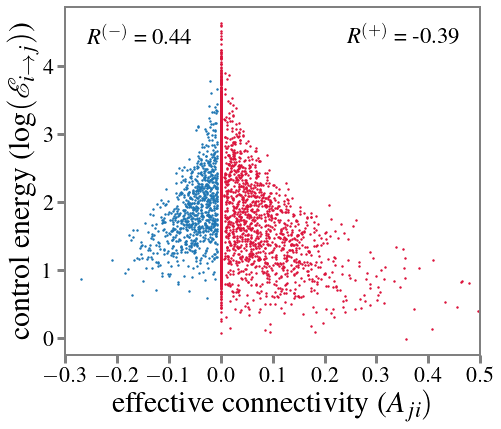

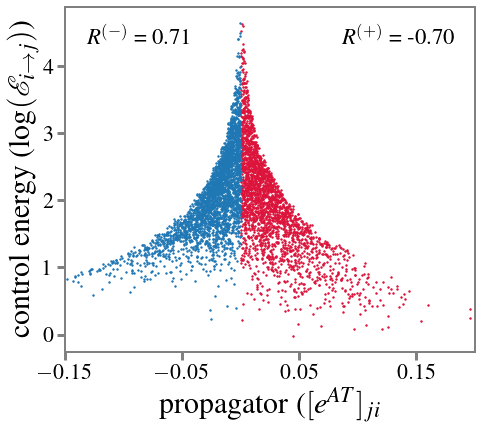

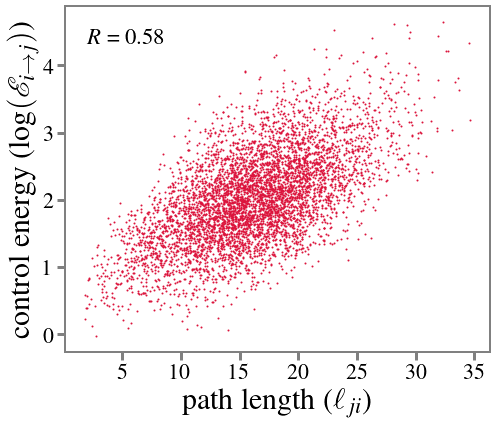

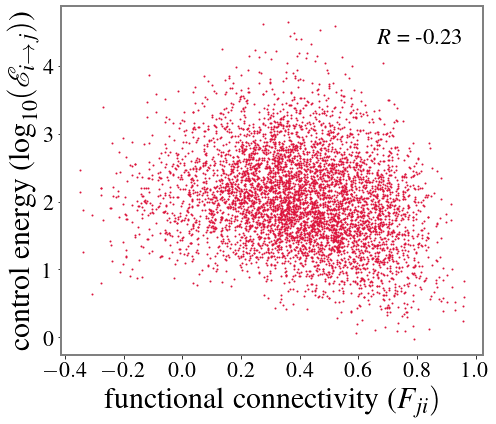

In [95]:
plt.figure(figsize=(7,6))

X=Ao[:,:,0]

Y=np.log10(ContMatrix[:,:,0])

idx =  np.where(np.eye(nroi)==0)
idx1 = np.where(np.logical_and(np.eye(nroi)==0,X>=0))
idx2 = np.where(np.logical_and(np.eye(nroi)==0,X<0))

my_scatterplot3(X,Y,idx,idx1,idx2,r'effective connectivity ($A_{ji})$',r'control energy ($\log(\mathcal{E}_{i \to j})$)',-0.3,0.5)
plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

plt.savefig('figs/fig2a.png')


plt.figure(figsize=(7,6))



X=EA_t10[:,:,0]-np.diag(np.diag(EA_t10[:,:,0]))
Y=np.log10(ContMatrix[:,:,0])

idx =  np.where(np.eye(nroi)==0)
idx1 = np.where(np.logical_and(np.eye(nroi)==0,X>=0))
idx2 = np.where(np.logical_and(np.eye(nroi)==0,X<0))

my_scatterplot3(X,Y,idx,idx1,idx2,r'propagator ($[e^{A T}]_{ji}$',r'control energy ($\log(\mathcal{E}_{i \to j})$)',-0.15,0.2)
plt.xticks(np.arange(-0.15,0.20,0.1))
plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

plt.savefig('figs/fig2b.png')

idx = np.where(np.eye(nroi)==0)

plt.figure(figsize=(7,6))

X=Ashortestpath[:,:,0]
Y=np.log10(ContMatrix[:,:,0])

my_scatterplot1(X,Y,idx,r'path length ($\mathcal{\ell}_{ji}$)',r'control energy ($\log(\mathcal{E}_{i \to j})$)')
plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

plt.tight_layout()


plt.savefig('figs/fig2c.png')

plt.figure(figsize=(7,6))

X=FC[:,:,0]

Y=np.log10(ContMatrix[:,:,0])

idx =  np.where(np.eye(nroi)==0)
idx1 = np.where(np.logical_and(np.eye(nroi)==0,X>=0))
idx2 = np.where(np.logical_and(np.eye(nroi)==0,X<0))

my_scatterplot1(X,Y,idx,r'functional connectivity ($F_{ji})$',r'control energy ($\log_{10}(\mathcal{E}_{i \to j})$)')


plt.tight_layout()
plt.savefig('figs/fig2d.png')



[0.39522553 0.40985795 0.66849791 0.68807566 0.55537945 0.15987761]
[0.03233663 0.04982182 0.0770012  0.05714588 0.03984586 0.05791926]


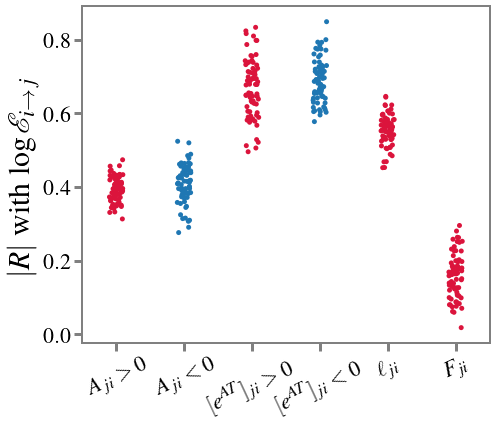

In [96]:
CorrVarious = np.zeros((nsbj,9))

for n in range(nsbj):

    idx =  np.where(np.eye(nroi)==0)

    X=Ao[:,:,n]
    Y=-np.log10(ContMatrix[:,:,n])
    idx1 = np.where(np.logical_and(np.eye(nroi)==0,X>=0))
    idx2 = np.where(np.logical_and(np.eye(nroi)==0,X<0))

    CorrVarious[n,0],p=spearmanr(X[idx1],Y[idx1]) #pearsonr(X[idx1],Y[idx1])

    CorrVarious[n,1],p=spearmanr(X[idx2],Y[idx2])
    
    X=EA_t10[:,:,n]-np.diag(np.diag(EA_t10[:,:,n]))
    Y=-np.log10(ContMatrix[:,:,n])
    idx1 = np.where(np.logical_and(np.eye(nroi)==0,X>=0))
    idx2 = np.where(np.logical_and(np.eye(nroi)==0,X<0))

    
    CorrVarious[n,2],p=spearmanr(X[idx1],Y[idx1])
    CorrVarious[n,3],p=spearmanr(X[idx2],Y[idx2])

    X=Ashortestpath[:,:,n]
    Y=-np.log10(ContMatrix[:,:,n])

    CorrVarious[n,4],p=spearmanr(X[idx],Y[idx])

    X=FC[:,:,n]
    Y=-np.log10(ContMatrix[:,:,n])

    CorrVarious[n,5],p=spearmanr(X[idx],Y[idx])

    
    
CorrVarious=np.abs(CorrVarious)

CV = np.zeros((nsbj,6))


CV[:,:]=CorrVarious[:,[0,1,2,3,4,5]]




YY=pd.DataFrame(data=np.column_stack((CV.reshape(-1),np.tile(np.arange(6),76) )),columns=['a','b'])

colors = np.ones((6,3))
colors[0,:]= [220./256, 20./256, 60./256]
colors[1,:]=[31./256, 119./256, 180./256]
colors[2,:]=[220./256, 20./256, 60./256]
colors[3,:]=[31./256, 119./256, 180./256]
colors[4,:]= [220./256, 20./256, 60./256]
colors[5,:]= [220./256, 20./256, 60./256]


fig,ax=plt.subplots(figsize=(7,6))

#seaborn.violinplot(data=YY,x="b",y="a",inner='quartile',palette=colors,width=1)
seaborn.stripplot(data=YY,x="b",y="a",palette=colors,jitter=True)


'''
box=plt.boxplot(CV[:,:],patch_artist=True,labels=[r'$A_{ij}>0}$',\
                            r'$ A_{ij}<0$',\
                            r'$[e^{AT}]_{ij}>0$',\
                              r'$[e^{AT}]_{ij}<0$',\
                             r'$\mathcal{\ell}_{ij}$',r'$F_{ij}$'],manage_ticks=True)
'''

plt.xticks(np.arange(6),size=22)
plt.yticks(size=22)

#plt.text(1,0.85,r'correlation with $\log\mathcal{E}_{i \to j}$',size=15)

plt.ylabel(r'$|R|$ with $\log \mathcal{E}_{i \to j}$',size=30)

'''
for patch,color in zip(box['boxes'],colors):
    patch.set_facecolor(color)

for patch in box['medians']:
    patch.set_color('black')
'''

plt.xlabel(' ',size=1)
ax.set_xticklabels(labels=[r'$A_{ji}>0$',\
                            r'$ A_{ji}<0$',\
                            r'$[e^{AT}]_{ji}>0$',\
                              r'$[e^{AT}]_{ji}<0$',\
                             r'$\mathcal{\ell}_{ji}$',r'$F_{ji}$'], rotation = 25)


plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

plt.tight_layout()


plt.savefig('figs/fig2e.png')

print(np.mean(CV,axis=0))
print(np.std(CV,axis=0))

    
#plt.show()
#print(CV)

# Fig 4

In [98]:
df_region = pd.read_csv("data/regionclustinfo4.txt", sep=" ", header=None)
nodes = df_region[0].tolist()
regions = df_region[2].tolist()
region_dict = dict(zip(nodes, regions) )

In [99]:
region_list = list(np.unique(np.array(list(region_dict.values()))))


In [113]:
subject_names = [file[:-4] for file in mat_files]

path = "./results/"

for region_name in region_list:
    print(region_name)
    new_path = path+region_name+"/"
    isExist = os.path.exists(new_path)

    # if the folder doesn't exist, create a new folder
    if not isExist:
        os.makedirs(new_path)
        
    target_list = target_nodes(region_dict,region_name)
   
    
    for centrality in ["page_rank","out_degree", "pq", "ratio_degree","modified_pq"]:
        if os.path.exists(new_path+centrality+".csv"): 
            print('done')
        else:
            arr = []
            for i in range(len(mat_files)):
                A = loadmat(fpath+mat_files[i])["A_sparse"]
                A=A.T
                Num_control_nodes, e_min = Nodes_energy_relation(A, centrality=centrality, target_list=target_list)
                arr.append(e_min)
            
            # arr is of shape 23 x 74
            emin_23subcols_arr = np.array(arr).T  # 74 x 23 arr. 23 refers to 23 subjects
        
            # create a dataframe to store energy for 23 subjects and for varying no. of control inputs
            df_23subj = pd.DataFrame(emin_23subcols_arr, columns=subject_names)
            df_23subj.insert(0, "Num_control_nodes", Num_control_nodes)
        
            # save the dataframe
            df_23subj.to_csv(new_path+centrality+".csv", index=False)


Cont
done
done
done
done
done
Default
done
done
done
done
done
DorsAttn
done
done
done
done
done
Limbic
done
done
done
done
done
SalVentAttn
done
done
done
done
done
SomMot
done
done
done
done
done
Subcortical
done
done
done
done
done
Vis
done
done
done
done
done


In [124]:


############################################ only for random  ############################################


seed_list = list(range(100,110,1))

subject_names = [file[:-4] for file in mat_files]

path = "./results/"

for region_name in region_list:
    print(region_name)
    new_path = path+region_name+"/"
    isExist = os.path.exists(new_path)

    # if the folder doesn't exist, create a new folder
    if not isExist:
        os.makedirs(new_path)
        
    target_list = target_nodes(region_dict,region_name)

    
    for centrality in ["random"]:
        if os.path.exists(new_path+centrality+".csv"): 
            print('done')

        else:
            arr = []
            for i in range(len(mat_files)):
                A = loadmat(fpath+mat_files[i])["A_sparse"]
                A = A.T
                sub_arr = []
            
                for seed in seed_list:
                    Num_control_nodes, e_min = Nodes_energy_relation(A, centrality=centrality, \
                                                                 target_list=target_list, seed=seed)
                    sub_arr.append(e_min)
                
                sub_arr = np.array(sub_arr )
                #print(mat_files[i])
                arr.append(np.mean(sub_arr, axis=0 ) )
    
            # arr is of shape 23 x 74
            emin_23subcols_arr = np.array(arr).T  # 74 x 23 arr. 23 refers to 23 subjects

            # create a dataframe to store energy for 23 subjects and for varying no. of control inputs
            df_23subj = pd.DataFrame(emin_23subcols_arr, columns=subject_names)
            df_23subj.insert(0, "Num_control_nodes", Num_control_nodes)

            # save the dataframe
            df_23subj.to_csv(new_path+centrality+".csv", index=False)


Cont
done
Default
done
DorsAttn
done
Limbic
done
SalVentAttn
done
SomMot
done
Subcortical
done
Vis
done


In [153]:
singleCnode_dict = {}

emin_singleNode = {}

centrality="singlenodemin"

path = "./results/"


for region_name in region_list:

    target_list = target_nodes(region_dict,region_name)

    all_emin = []
    emin_nodes = []
    
    new_path = path+region_name+"/"

    if os.path.exists(new_path+centrality+".csv"): 
        print('done')

    else:

        for j in range(len(mat_files)):
            print(j)
            A= loadmat(fpath+mat_files[j])["A_sparse"]
            A=A.T
            #print(mat_files[0][:-4])

            N = len(A)# N=74 in our case

            C = compute_C(N, target_list)# output target matrix


            singleCNode_energy_dict = {}

            # remove all nodes that belong to target list
    
            control_nodeSet = list(range(1, N+1))
            for node in target_list: 
                control_nodeSet.remove(node)
            #print("ntargets:", len(target_list))
            #print("nControl_set:", len(control_nodeSet))


            for i in control_nodeSet:
                # compute B 
                # remember to sort the control nodes before constructing the input matrix B
                B = compute_B(N, [i] )

                # check Kalman rank    
                d = target_controllability_matrix(A.T, B, C)
                rank_d = np.linalg.matrix_rank(d, tol=1E-50).item(0) # Full rank matrix 
                if rank_d!=len(target_list):
                    print("rank_d != S for Nd = ",B.shape[1])
                    continue

                # compute W
                W = solve_continuous_lyapunov(A.T, -np.matmul(B, B.T)) 

                W_c = np.matmul(C, np.matmul(W, C.T))

                # compute  e_min if possible
                singleCNode_energy_dict[i]=compute_e_min( min(np.linalg.eigvals(W_c)) )
                 
            
            sorted_d = dict( sorted(singleCNode_energy_dict.items(), key=operator.itemgetter(1),reverse=False)) # l2h
        
            emin_nodes.append(list(sorted_d.keys())) 
        
            # top 10 control nodes based on low 2 high single node control energy
            control_nodes = list(sorted_d.keys())      

            n_control = len(control_nodes)
    
            min_evals_W = np.zeros((n_control))

            Num_control_nodes=list(range(n_control,0,-1))

            for n in range(n_control):
                #print(control_nodes[:n_control-n])
                B = compute_B(N, sorted(control_nodes[:n_control-n]) )
                W = solve_continuous_lyapunov(A.T, -np.matmul(B, B.T))  # in the controllability framework, A[i,j] is from j to i 
                W_c = np.matmul(C, np.matmul(W, C.T))

                minW=min(np.linalg.eigvals(W_c))
            
                if(minW>1.0E-12):
                    min_evals_W[n]=minW
                else:
                    min_evals_W[n]=1.0E-12
                    
            e_min_list = compute_e_min(min_evals_W)
                
            #return (Num_control_nodes, e_min_list)
        
            '''
            for seed in seed_list:
                Num_control_nodes, e_min = AllNodes_energy_relation(A, centrality=centrality, \
                                                                 target_list=target_list, seed=seed)
                sub_arr.append(e_min)
                
            sub_arr = np.array(sub_arr )
        
        
        
            B = compute_B(N, control_nodes )
            # compute W
            W = solve_continuous_lyapunov(A.T, -np.matmul(B, B.T)) 

            W_c = np.matmul(C, np.matmul(W, C.T))

            #print("Emin: ", compute_e_min( min(np.linalg.eigvals(W_c)) ))

            '''
            all_emin.append(e_min_list)
        
        emin_singleNode[region_name] = np.array(all_emin)
   
        singleCnode_dict[region_name]=np.array(emin_nodes)

        df_23subj = pd.DataFrame(emin_singleNode[region_name].T, columns=subject_names)
        df_23subj.insert(0, "Num_control_nodes", Num_control_nodes)
        # save the dataframe
        df_23subj.to_csv(new_path+centrality+".csv", index=False)
        


done
done
done
done
done
done
done
done


In [154]:

if(os.path.exists("./results/"+"singleNode_energy.json")):
    print('done')
else:
    for key in singleCnode_dict.keys():
        arr=emin_singleNode[key]
        emin_singleNode[key]=arr.tolist()  #np.asarray(arr)

    for key in singleCnode_dict.keys():
        arr=singleCnode_dict[key]
        singleCnode_dict[key]=arr.tolist()  #np.asarray(arr)

    with open("./results/"+"singleNode_energy.json", 'w') as f:
        json.dump(emin_singleNode, f)
        
    with open("./results/"+"singleNode_nodes.json", 'w') as f:
        json.dump(singleCnode_dict, f)


done


In [155]:
path = "./results/"

centrality_criteria_list = ["singlenodemin","out_degree", "pq", "ratio_degree", "page_rank","random"]


plta = np.zeros((len(region_list),len(centrality_criteria_list),76))
pltb = np.zeros((len(region_list),len(centrality_criteria_list),76))
r=0

nc=2


for region_name in region_list:
    
    print(region_name)
    new_path = path+region_name+"/"
        
    target_list = target_nodes(region_dict,region_name)


    c=0
    for centrality in centrality_criteria_list:
        
        df = pd.read_csv(new_path+centrality+".csv")


        plta[r,c,:]=np.log10(np.array(df.iloc[-nc,1:].tolist()))
        pltb[r,c,:]=np.log10(np.array(df.iloc[-nc,1:].tolist()))/len(target_list)
            
        c=c+1
        
    r=r+1
    


Cont
Default
DorsAttn
Limbic
SalVentAttn
SomMot
Subcortical
Vis


[ 1  2  3  4  5  6 11 12 13 14 15 16 21 22 23 24 25 26 31 32 33 34 35 36
 41 42 43 44 45 46 51 52 53 54 55 56 61 62 63 64 65 66 71 72 73 74 75 76]
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7

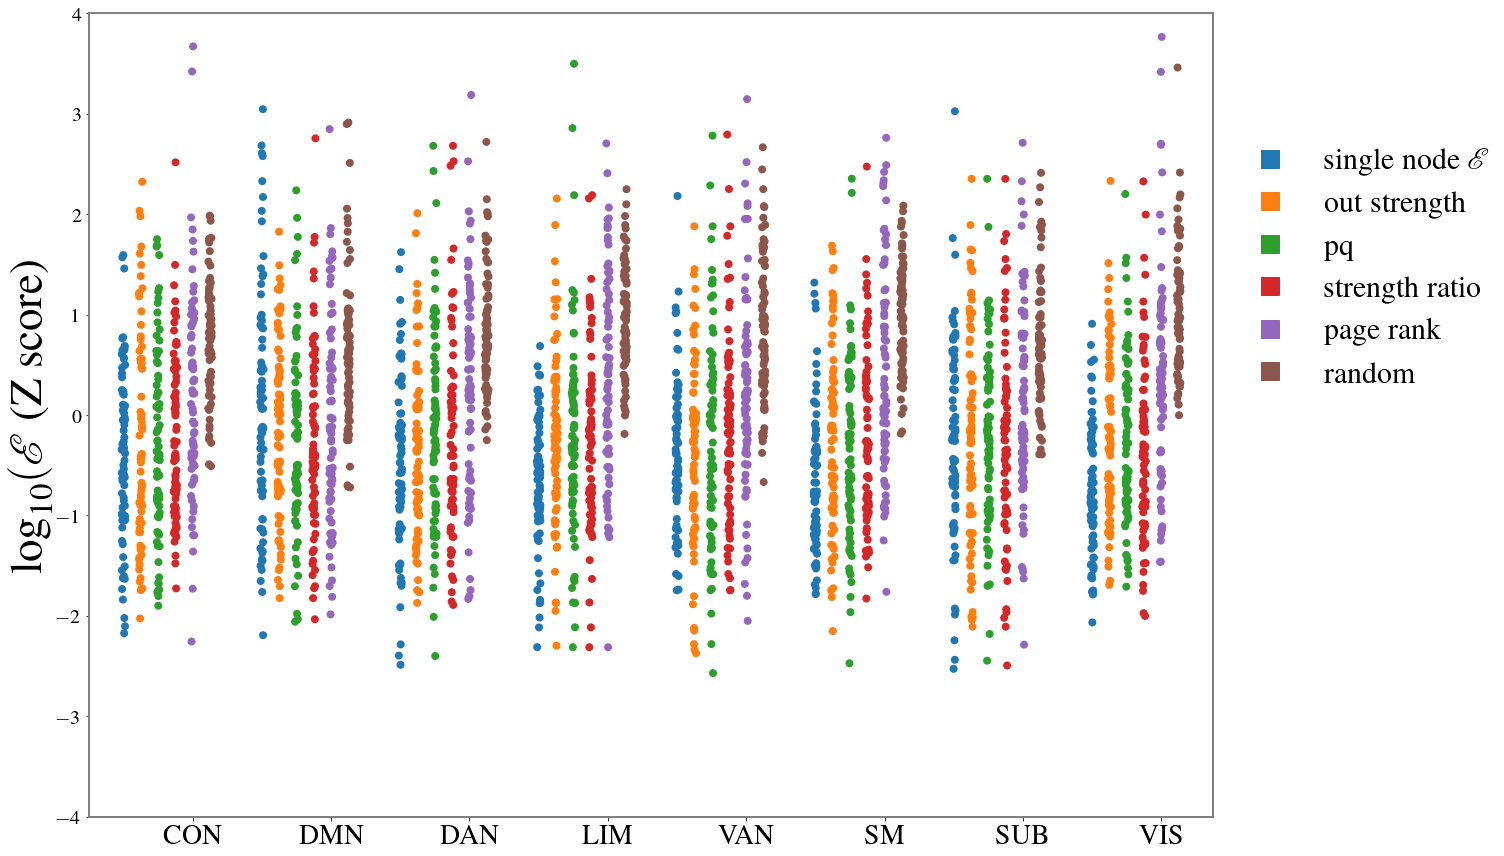

In [139]:
base = 0
pos = list(range(1,len(centrality_criteria_list)+1))
for q in range(len(region_list)-1):
    base = base + 10
    pos = pos + list(range(base+1,base+len(centrality_criteria_list)+1))

pos = np.array(pos)
print(pos)

pltz=np.zeros(np.shape(pltb))

for a in range(8):
    pltz[a,:,:]=(plta[a,:,:]-np.mean(plta[a,:,:]))/np.std(plta[a,:,:])


XX=np.reshape(pltz,(len(region_list)*len(centrality_criteria_list),76)).T
    
YY=-10*np.ones((76,8*8))

YY[:,0:6]=XX[:,0:6]
YY[:,8:14]=XX[:,6:12]
YY[:,16:22]=XX[:,12:18]
YY[:,24:30]=XX[:,18:24]
YY[:,32:38]=XX[:,24:30]
YY[:,40:46]=XX[:,30:36]
YY[:,48:54]=XX[:,36:42]
YY[:,56:62]=XX[:,42:48]

colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

colors8=colors[:8]

#plt.violinplot(XX,colors=colors)



YY=pd.DataFrame(data=np.column_stack((YY.reshape(-1),np.tile(np.arange(64),76),\
                                      np.tile(np.repeat(np.arange(8),8),76))),columns=['a','b','c'])

#print(XX)

colors = colors * 8


print(colors)

plt.figure(figsize=(21,12))


#seaborn.violinplot(data=YY,x="b",y="a",inner='quartile',palette=colors8,width=1.5)
seaborn.stripplot(data=YY,x="b",y="a",s=8,palette=colors8,jitter=True)

    

'''                
box=plt.boxplot(np.reshape(pltz,(len(region_list)*len(centrality_criteria_list),76)).T,positions=pos,patch_artist=True)
'''

plt.xlim(-2,63)
plt.ylim(-4,4)
plt.yticks(size=20)


'''
colors = [u'#8c564b', u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd'] * len(region_list)



for patch,color in zip(box['boxes'],colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

    
for patch in box['medians']:
    patch.set_color('black')
'''

region_names_short = ['CON', 'DMN', 'DAN', 'LIM', 'VAN', 'SM','SUB', 'VIS']


plt.xticks(range(4,8*len(region_list)+4,8),labels=region_names_short,size=28)    

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(len(centrality_criteria_list))]
labels = [ r"single node $\mathcal{E}$", "out strength", "pq", "strength ratio", "page rank","random"]
legend = plt.legend(handles, labels, markerscale=3,prop={'size': 30},loc=3, framealpha=1, frameon=False,bbox_to_anchor=(1,0.5))
    
plt.ylabel(r'$\log_{10}(\mathcal{E}$ (Z score)',size=45)
plt.xlabel('',size=1)
    
plt.tight_layout()
plt.savefig('figs/fig4.png')


# Fig 5

In [146]:
# target region centrality dict
import scipy.stats as stats
region_centr_dict = {}

path = "results/"
for region_name in region_list:

    print(region_name)
    new_path = path+region_name+"/"


    row = []
    col = []
    ttest_val = []
    pval_list = []
    for centrA in ["singlenodemin","out_degree", "pq", "ratio_degree", "page_rank", "random"]:
        
        
        df = pd.read_csv(new_path+centrA+".csv")
        emin_centrA = np.log(df.iloc[:,1:].mean(axis=1).tolist())
    
        centr_list = ["singlenodemin","out_degree", "pq", "ratio_degree", "page_rank", "random"]
            #centr_list.remove(centrA)

        for centrB in centr_list:

            if centrA==centrB:
                    pval_list.append(1)
            else:
                df = pd.read_csv(new_path+centrB+".csv")
                emin_centrB = np.log(df.iloc[:,1:].mean(axis=1).tolist())

                varA = np.var(emin_centrA)
                varB = np.var(emin_centrB)
                stat, pval = stats.ttest_ind(emin_centrB,emin_centrA, alternative="greater")
                pval_list.append(pval)
    # p<0.005 we reject null hypothesis that two related paired samples come from the same distribution
    pval_arr = np.array(pval_list).reshape(6,6)
    pval_arr = -np.log10(pval_arr)
    pval_arr = np.abs(pval_arr)
    ind = np.argmax(np.sum(pval_arr, axis=1))
    region_centr_dict[region_name]=centr_list[ind]
    


Cont
Default
DorsAttn
Limbic
SalVentAttn
SomMot
Subcortical
Vis


In [147]:
region_centr_dict

{'Cont': 'out_degree',
 'Default': 'out_degree',
 'DorsAttn': 'singlenodemin',
 'Limbic': 'singlenodemin',
 'SalVentAttn': 'out_degree',
 'SomMot': 'singlenodemin',
 'Subcortical': 'pq',
 'Vis': 'singlenodemin'}

In [149]:
coords = np.loadtxt('data/roicenters2.txt',delimiter=',')


df_region = pd.read_csv("data/regionclustinfo4.txt", sep=" ", header=None)
nodes = df_region[0].tolist()

regions = df_region[2].tolist()

region_dict = dict(zip(nodes, regions) )
region_dict

region_names = np.unique(np.array(list(region_dict.values())))
cmap = plt.cm.get_cmap('Set1')

# blue = cmap(0)[:3]
node_color=[]
#node_coord_matrix=[]


for key, value in region_dict.items():
    for i in range(len(region_names)):
        if value == region_names[i]:   
            node_color.append( cmap(i)[:3] )
            #node_coord_matrix.append( node_coord_dict[key] )

region_names_short = ['CON', 'DMN', 'DAN', 'LIM', 'VAN', 'SM','SUB', 'VIS']


In [157]:
region_rank_dict = {}

for region_name, centrality in region_centr_dict.items():
        print(region_name)
        target_list = target_nodes(region_dict, region_name)
        
        if(centrality=="singlenodemin"):
            f=open("./results/singleNode_nodes.json")          #singleNode_nodes.json")
            data = json.load(f)
            all_ranked_lists=data[region_name]
            #print(all_ranked_lists)
        
        else:
            all_ranked_lists = get_ranked_lists(fpath, mat_files, centrality, target_list,A_type="DCM")
            #print(all_ranked_lists)
           
            
        ranks = np.zeros((76,74))
        m=len(all_ranked_lists[0])
        
        for n in range(76):
            list1 = all_ranked_lists[n]
            list1=list1+target_list
            list1=np.array(list1)-1
            ranks[n,:]= np.argsort(list1)
        #all_ranked_lists[0]
        
        region_rank_dict[region_name]=ranks
        
        
        

Cont
Default
DorsAttn
Limbic
SalVentAttn
SomMot
Subcortical
Vis


In [166]:
# rememver not to use> set for zipping, only use lists for zipping
for region_name, centrality in region_centr_dict.items():
    
    print(region_name,centrality)
    if os.path.exists("./results/"+region_name+"/"+centrality+'.json'): 
        print('done')
    else:
        info_dict = get_statistics(fpath, mat_files, region_dict, region_name=region_name, centrality=centrality)
        print(info_dict)
        
        with open("./results/"+region_name+"/"+centrality+'.json', 'w') as f:
            json.dump(info_dict, f)


Cont out_degree
done
Default out_degree
done
DorsAttn singlenodemin
done
Limbic singlenodemin
done
SalVentAttn out_degree
done
SomMot singlenodemin
done
Subcortical pq
done
Vis singlenodemin
done


In [169]:
best_agg_type_dict = {}

for region_name, centrality in region_centr_dict.items():
    
    f = open("./results/"+region_name+"/"+centrality+'.json')
    
    # returns JSON object as
    # a dictionary
    data = json.load(f)
    
    rank_agg_types = list(data["rank_agg"].keys())
    
    energy_list = []
    for key in rank_agg_types:
        energy_list.append(data["rank_agg"][key]["avg_emin_agg"])
    ind = np.argmin(energy_list)
        
    print(data["region_name"], rank_agg_types[ind])
    best_agg_type_dict[data["region_name"]] = rank_agg_types[ind]


Cont average
Default dowdall
DorsAttn average
Limbic dowdall
SalVentAttn dowdall
SomMot average
Subcortical crank
Vis average


In [170]:
percent_array=[]
count_array=[]

for region_name in region_centr_dict.keys():
    target_list = target_nodes(region_dict, region_name)
    centrality = region_centr_dict[region_name]
    print(region_name,centrality)
    if(centrality=="singlenodemin"):
        f=open("./results/singleNode_nodes.json")          #singleNode_nodes.json")
        data = json.load(f)
        all_ranked_lists=data[region_name]
    else:
        all_ranked_lists = get_ranked_lists(fpath, mat_files, centrality, target_list)
    
    cNodes_23sub = np.array(all_ranked_lists)[:, :10].flatten() # consider only top priority nodes
    
    
    percent_list = []
    count_list=[]
    for region in region_centr_dict.keys():
        targets_of_name = target_nodes(region_dict, region)
        common = sum([node in targets_of_name for node in cNodes_23sub])
        count_list.append(common)
        percent = np.round((common/len(cNodes_23sub)) * 100,2)
        percent_list.append( percent )
    percent_array.append(percent_list)    
    count_array.append(count_list)

Cont out_degree
Default out_degree
DorsAttn singlenodemin
Limbic singlenodemin
SalVentAttn out_degree
SomMot singlenodemin
Subcortical pq
Vis singlenodemin
CPU times: user 3min 9s, sys: 6min 53s, total: 10min 2s
Wall time: 1min 33s


[7.16393705e-20 1.03531856e-09 9.99999945e-01 2.17092433e-05
 8.45783297e-01 9.99731818e-01 9.99925970e-01 5.41043114e-03
 1.81893034e-17 9.99703177e-01 8.62957047e-19 4.44397625e-01
 4.02464293e-01 8.17700725e-01 2.89660851e-01 9.63143485e-05
 5.99370575e-02 4.18776478e-03 2.40539602e-01 5.27895259e-01
 2.10107391e-01 6.81397500e-01 5.74736142e-09 9.99966947e-01
 3.46557498e-01 4.44397625e-01 9.82682783e-02 2.10107391e-01
 2.52356053e-01 1.27504403e-28 1.63427102e-11 9.99999982e-01
 7.65786452e-01 9.94823567e-01 9.98171774e-01 5.05180494e-01
 6.37123122e-02 1.15652334e-01 9.57320304e-01 2.21444052e-03
 1.33121020e-02 7.72402581e-01 9.99998764e-01 1.87333565e-07
 3.10745678e-01 2.40351475e-11 1.01361907e-02 3.89026760e-01
 5.09270956e-06 8.53418539e-01 5.31060012e-04 5.39977444e-01
 2.56495653e-01 3.87561142e-01 7.18811218e-01 1.72240168e-02]


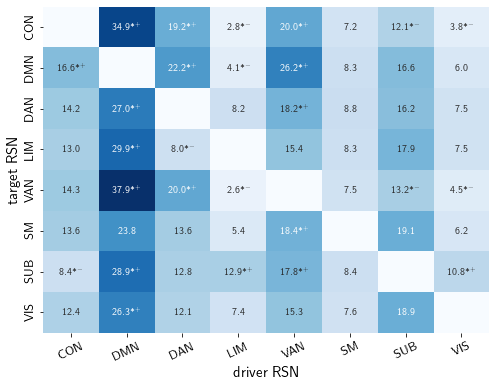

In [171]:
sz = np.zeros(8)
r=0
for region_name in region_list:
    ll=[r for r in regions if r==region_name]
    sz[r]=len(ll)
    r=r+1

sz1=sz/np.sum(sz)*100
    


#from scipy.stats import binom
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection

percent_array_sig_p = np.zeros(np.shape(percent_array))
percent_array_sig_m = np.zeros(np.shape(percent_array))

alpha=0.05  #/(8*8*2)


for r in range(8):
    for s in range(8):
        
        if r==s:
            percent_array_sig_p[r,s]=1
            percent_array_sig_m[r,s]=1
            

        else:
            n=np.array(count_array)[r,s]
            nc=sz[s]*76-n
            m=760-n
            mc=74*76-m-n-nc
            
            table = np.array( [[n,nc],[m,mc]])
        
            oddsr, p = fisher_exact(table, alternative='less')
            
            percent_array_sig_m[r,s]=p
            
            oddsr, p = fisher_exact(table, alternative='greater')
                
            percent_array_sig_p[r,s]=p
                        
                                               
   

percent_array_sig_p=np.array(percent_array_sig_p)
percent_array_sig_m=np.array(percent_array_sig_m)

idx=np.where(np.eye(8)==0)

print(percent_array_sig_p[idx])

pvals = np.concatenate((percent_array_sig_p[idx],percent_array_sig_m[idx]))
      
rej,corrpvals=fdrcorrection(pvals, alpha=0.05, method='indep', is_sorted=False)

percent_array_sig_p[idx]=corrpvals[:56]
percent_array_sig_m[idx]=corrpvals[56:]


label_array = []

for r in range(8):
    label_list=[]
    for s in range(8):
        if r==s:
            label_list.append('')
        
        else:
            sym=''
            
            if(-np.log10( percent_array_sig_m[r,s])>-np.log10(alpha)):
                sym=r'*$^-$'
            if(-np.log10( percent_array_sig_p[r,s])>-np.log10(alpha)):
                sym=r'*$^+$'


            label_list.append("%(pr)1.1f" % {"pr": np.array(percent_array)[r,s]}+sym)

    label_array.append(label_list)


    
plt.figure(figsize=(8,6))
sns.heatmap(percent_array, annot=np.array(label_array), fmt = '',cmap="Blues",
           xticklabels=region_names_short, yticklabels=region_names_short, cbar=None) #_kws={'label': '% top 10 nodes'})
sns.set(font_scale=1.1)
    
plt.xticks(rotation=25, fontsize=10) 
plt.yticks(fontsize=10) 
plt.xlabel("% distribution of Control nodes of 23 Subjects")
plt.ylabel("Brain cluster")

plt.xticks(rotation=25, fontsize=10) 
plt.yticks(fontsize=13) 
plt.xticks(fontsize=13)
plt.xlabel("driver RSN",size=15) #("% of Aggregated Driver nodes",size=15)
plt.ylabel("target RSN",size=15)
plt.tight_layout


#plt.savefig("./target/json_results/"+"top10_all_nodes.png", facecolor="white", bbox_inches="tight")

plt.savefig("./figs/"+"fig5a.png", facecolor="white", bbox_inches="tight")

In [172]:
region_list = list(region_centr_dict.keys())
percent_array_agg=[]
count_array_agg=[]

for name in region_list:
    region_name=name
    centrality = region_centr_dict[region_name]
    agg_type = 'average' #best_agg_type_dict[region_name]

    f = open("./results/"+region_name+"/"+centrality+'.json')

    # returns JSON object as
    # a dictionary
    data = json.load(f)

    #print(data["region_name"])
    #print(data["target_nodes"])
    #print(data["rank_agg"][agg_type]["percent_agg_nodes"])

    agg_nodes = data["rank_agg"][agg_type]["agg_control_nodes"]
    
    percent_list = []
    count_list=[]
    for region in region_list:
        targets_of_name = target_nodes(region_dict, region)
        common = set( targets_of_name ).intersection(set(agg_nodes))
        percent = np.round((len(common)/len(agg_nodes)) * 100,2)
        percent_list.append( percent )
        count_list.append(len(common))
    percent_array_agg.append(percent_list) 
    count_array_agg.append(count_list)
    
percent_array_agg = np.array(percent_array_agg)

[10. 16.  9.  5. 11.  6. 12.  5.]
[[1.00000000e+00 5.25119139e-03 3.50347957e-01 1.00000000e+00
  4.59707192e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [1.28548946e-01 1.00000000e+00 9.74192602e-02 1.00000000e+00
  3.61326912e-02 1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [7.89154026e-01 1.35650588e-01 1.00000000e+00 1.00000000e+00
  4.59707192e-01 5.95281782e-01 5.11477409e-01 1.00000000e+00]
 [1.00000000e+00 3.31110032e-02 7.50818395e-01 1.00000000e+00
  8.22098710e-01 5.95281782e-01 1.00000000e+00 1.32256702e-01]
 [7.89154026e-01 5.21902347e-04 3.50347957e-01 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [7.89154026e-01 6.90201406e-01 9.74192602e-02 1.00000000e+00
  4.59707192e-01 1.00000000e+00 5.11477409e-01 1.00000000e+00]
 [1.00000000e+00 6.90201406e-01 3.50347957e-01 1.58678841e-02
  8.22098710e-01 1.00000000e+00 1.00000000e+00 1.32256702e-01]
 [7.89154026e-01 3.70026783e-01 7.50818395e-01 5.26685474e-01
  8.22098710e-01 1.00000000e+

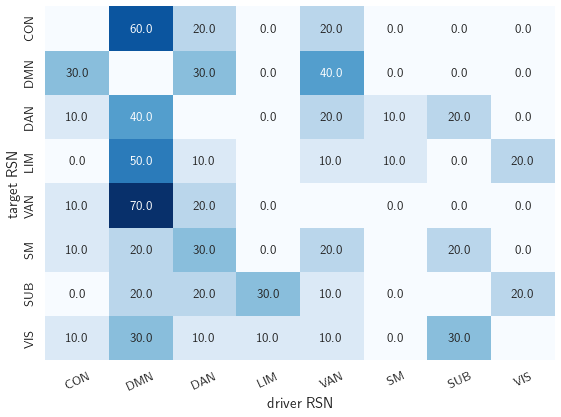

In [174]:
sz = np.zeros(8)
r=0
for region_name in region_list:
    ll=[r for r in regions if r==region_name]
    sz[r]=len(ll)
    r=r+1

sz1=sz/np.sum(sz)*100
    
print(sz)


#from scipy.stats import binom
from scipy.stats import fisher_exact
    
percent_array_sig_p = np.zeros(np.shape(percent_array))
percent_array_sig_m = np.zeros(np.shape(percent_array))

alpha=0.05 #/(8*8*2)



for r in range(8):
    for s in range(8):
        
        if r==s:
            percent_array_sig_p[r,s]=1
            percent_array_sig_m[r,s]=1
            label_list.append('')

        else:
                       
            
            n=np.array(count_array_agg)[r,s]
            nc=sz[s]-n
            m=10-n
            mc=74-nc-n-m
                                
            table = np.array( [[n,nc],[m,mc]])
            
        
            oddsr, p = fisher_exact(table, alternative='less')
            
            #print(oddsr,p)
                        
            percent_array_sig_m[r,s]=p
            
            oddsr, p = fisher_exact(table, alternative='greater')

            #print(oddsr,p)
          
            percent_array_sig_p[r,s]=p
          

            
         
print(percent_array_sig_p)

        
percent_array_sig_p=np.array(percent_array_sig_p)
percent_array_sig_m=np.array(percent_array_sig_m)

idx=np.where(np.eye(8)==0)


pvals = np.concatenate((percent_array_sig_p[idx],percent_array_sig_m[idx]))
      
rej,corrpvals=fdrcorrection(pvals, alpha=alpha, method='indep', is_sorted=False)

percent_array_sig_p[idx]=corrpvals[:56]
percent_array_sig_m[idx]=corrpvals[56:]

print(percent_array_sig_p)



label_array = []

for r in range(8):
    label_list=[]
    for s in range(8):
        if r==s:
            label_list.append('')
        
        else:
            sym=''
            
            if(-np.log10( percent_array_sig_m[r,s])>-np.log10(alpha)):
                sym=r'*$^-$'
            if(-np.log10( percent_array_sig_p[r,s])>-np.log10(alpha)):
                sym=r'*$^+$'


            label_list.append("%(pr)1.1f" % {"pr": np.array(percent_array_agg)[r,s]}+sym)

    label_array.append(label_list)



plt.figure(figsize=(8,6))
sns.heatmap(percent_array_agg, annot=np.array(label_array), fmt = '',cmap="Blues",
           xticklabels=region_names_short, yticklabels=region_names_short, cbar=None) #_kws={'label': '% top 10 nodes'})
sns.set(font_scale=1.1)

plt.xticks(rotation=25, fontsize=10) 
plt.yticks(fontsize=10) 
plt.xlabel("% distribution of Control nodes of 23 Subjects")
plt.ylabel("Brain cluster")

plt.xticks(rotation=25, fontsize=10) 
plt.yticks(fontsize=13) 
plt.xticks(fontsize=13)
plt.xlabel("driver RSN",size=15) #("% of Aggregated Driver nodes",size=15)
plt.ylabel("target RSN",size=15)
plt.tight_layout()

plt.savefig("./figs/fig5b.png", facecolor="white", bbox_inches="tight")





# Fig7

<Figure size 1000x1000 with 0 Axes>

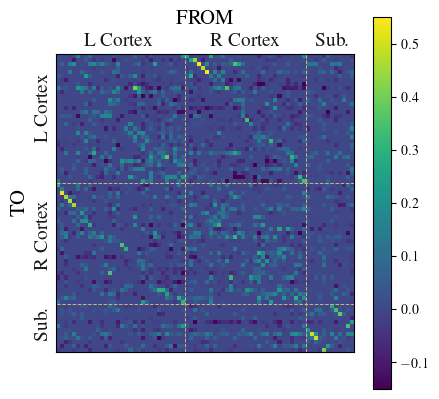

<Figure size 1000x1000 with 0 Axes>

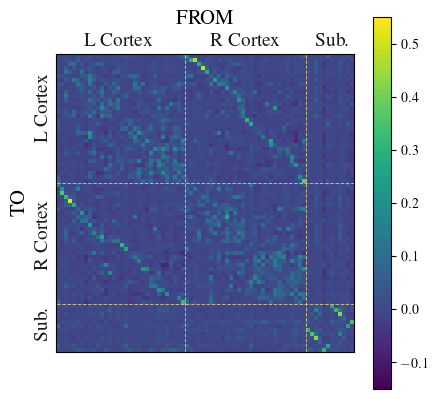

<Figure size 1000x1000 with 0 Axes>

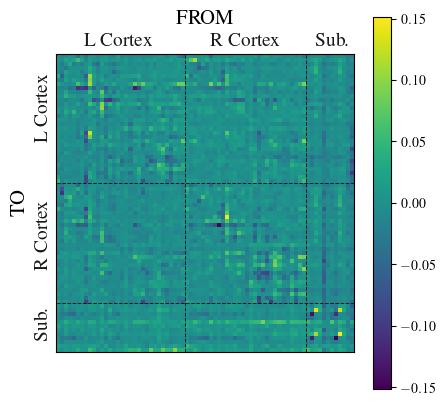

In [182]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

plt.figure(figsize=(10, 10))
plt.matshow(dediag(Ao[:,:,0]),vmin=-0.15,vmax=0.55)
#vv=np.array([0,31.5,61.5])
vv=np.array([15,46.5,68])
vv1=np.array([6,37.5,64])
labs=['L Cortex','R Cortex','Sub.']
labs1=['L Cortex','R Cortex','Sub.']

plt.xticks(vv,labels=labs,size=14)
plt.yticks(vv1,labels=labs1,rotation=90,size=14)
plt.tick_params(direction='out', length=0, width=2, colors='k',grid_color='r', grid_alpha=0.5)
plt.colorbar()
plt.vlines(31.5,73.5,-0.5,color='y',linestyles='dashed',linewidth=0.7)
plt.vlines(61.5,73.5,-0.5,color='y',linestyles='dashed',linewidth=0.7)
plt.hlines(31.5,73.5,-0.5,color='y',linestyles='dashed',linewidth=0.7)
plt.hlines(61.5,73.5,-0.5,color='y',linestyles='dashed',linewidth=0.7)
plt.title('FROM',size=15)
plt.ylabel('TO',size=15)
plt.savefig('figs/fig7a.png')


plt.figure(figsize=(10, 10))
plt.matshow(dediag(np.mean(Ao,axis=2).T),vmin=-0.15,vmax=0.55)
plt.colorbar()
plt.xticks(vv,labels=labs,size=14)
plt.yticks(vv1,labels=labs1,rotation=90,size=14)
plt.tick_params(direction='out', length=0, width=2, colors='k',grid_color='r', grid_alpha=0.5)
plt.vlines(31.5,73.5,-0.5,color='y',linestyles='dashed',linewidth=0.7)
plt.vlines(61.5,73.5,-0.5,color='y',linestyles='dashed',linewidth=0.7)
plt.hlines(31.5,73.5,-0.5,color='y',linestyles='dashed',linewidth=0.7)
plt.hlines(61.5,73.5,-0.5,color='y',linestyles='dashed',linewidth=0.7)
plt.title('FROM',size=15)
plt.ylabel('TO',size=15)
plt.savefig('figs/fig7b.png')


plt.figure(figsize=(10, 10))
plt.matshow(np.mean(Ao,axis=2).T-np.mean(Ao,axis=2))
plt.xticks(vv,labels=labs,size=14)
plt.yticks(vv1,labels=labs1,rotation=90,size=14)
plt.tick_params(direction='out', length=0, width=2, colors='k',grid_color='r', grid_alpha=0.5)
plt.colorbar()
plt.vlines(31.5,73.5,-0.5,color='k',linestyles='dashed',linewidth=0.7)
plt.vlines(61.5,73.5,-0.5,color='k',linestyles='dashed',linewidth=0.7)
plt.hlines(31.5,73.5,-0.5,color='k',linestyles='dashed',linewidth=0.7)
plt.hlines(61.5,73.5,-0.5,color='k',linestyles='dashed',linewidth=0.7)
plt.title('FROM',size=15)
plt.ylabel('TO',size=15)
plt.savefig('figs/fig7c.png')


# Fig 8 

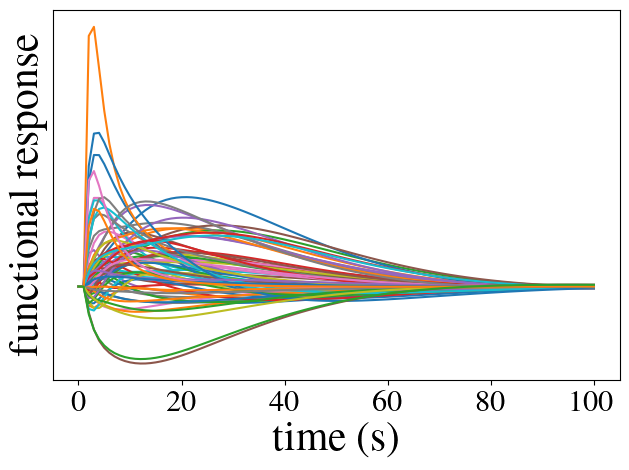

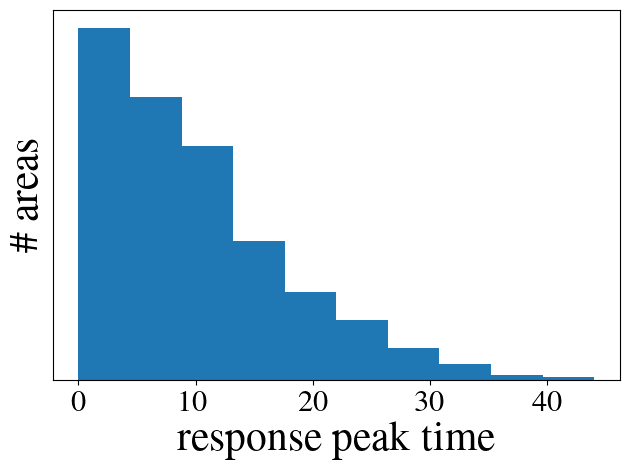

In [184]:
Amean = np.mean(A,axis=2)

np.random.seed(10)

maxtimes = np.zeros(74*74)

for m in range(74):
    x = np.zeros(74) #random.normal(0,1,74)
    x[m]=100

    xt = np.zeros((101,74));
    xt[0,:]=x

    for n in range(100):
        xt[n+1,:]=np.matmul(expm(Amean*n),x)

    if(m==0):
        #plt.plot(np.linspace(0,20,101),xt[:,0])
        plt.plot(np.linspace(0,100,101),xt[:,1:])
        #plt.plot(np.linspace(0,100,101),xt[:,3])
        #plt.plot(np.linspace(0,100,101),xt[:,5])
        #plt.plot(np.linspace(0,100,101),xt[:,7])
        #plt.plot(np.linspace(0,100,101),xt[:,9])
        #plt.plot(np.linspace(0,100,101),xt[:,11])
        plt.xlabel('time (s)',size=30)
        plt.xticks(size=22)
        plt.yticks([])
        plt.ylabel(r'functional response',size=30)
        plt.tight_layout()
        plt.savefig('figs/fig8a.png')
        
    maxtimes[m*74:(m+1)*74]=np.argmax(np.abs(xt),axis=0)

plt.figure()
#print(np.argmax(np.abs(xt),axis=0))
#plt.plot(np.sort(np.argmax(np.abs(xt),axis=0)),np.arange(1,75)/74.)
#plt.hist(np.argmax(np.abs(xt),axis=0))
plt.hist(maxtimes)
plt.ylabel('\# areas',size=30)
plt.xticks(size=22)
plt.yticks([])
plt.xlabel(r'response peak time',size=30)
plt.tight_layout()
plt.savefig('figs/fig8b.png')


# Fig 9 

In [185]:
in_degree= np.sum(np.abs(Ao),axis=0)
out_degree = np.sum(np.abs(Ao),axis=1)

in_degree1= np.sum(Ao,axis=0)
out_degree1 = np.sum(Ao,axis=1)


FC_degree = np.sum(FC,axis=1)


In [186]:
ContInputEn= np.sum(np.log10(ContMatrix),axis=1)
ContTargetEn= np.sum(np.log10(ContMatrix),axis=0)


In [187]:
CorrAEn=np.zeros((nsbj,4))

CorrFCEn=np.zeros((nsbj,2))

for n in range(nsbj):
    CorrAEn[n,0],p=pearsonr(in_degree[:,n],ContInputEn[:,n])
    CorrAEn[n,1],p=pearsonr(out_degree[:,n],ContTargetEn[:,n])
    CorrAEn[n,2],p=pearsonr(in_degree[:,n],ContTargetEn[:,n])
    CorrAEn[n,3],p=pearsonr(out_degree[:,n],ContInputEn[:,n])
    CorrFCEn[n,0],p=pearsonr(FC_degree[:,n],ContInputEn[:,n])
    CorrFCEn[n,1],p=pearsonr(FC_degree[:,n],ContTargetEn[:,n])

print(np.mean(CorrAEn,axis=0))
print(np.std(CorrAEn,axis=0))
print(np.mean(CorrFCEn,axis=0))
print(np.std(CorrFCEn,axis=0))

[-0.09779071  0.00389768 -0.71805823 -0.70703736]
[0.17306882 0.15087258 0.06564727 0.05309394]
[ 0.09611109 -0.19633553]
[0.16354801 0.23209292]


In [188]:
consistencyInDegree = np.zeros(nroi)
consistencyOutDegree = np.zeros(nroi)
consistencyFCDegree1 = np.zeros(nroi)

for n in range(nroi):
    consistencyInDegree[n] = pearsonr(in_degree[n,:])/np.mean(in_degree[n,:])
    consistencyOutDegree[n] = np.std(out_degree[n,:])/np.mean(out_degree[n,:])
    consistencyFCDegree[n] = np.std(FC_degree[n,:])/np.mean(FC_degree[n,:])


TypeError: pearsonr() missing 1 required positional argument: 'y'

In [189]:
consistencyContInput = np.zeros(nsbj)
consistencyContTarget = np.zeros(nsbj)

for n in range(nsbj):
    consistencyContInput[n],p = pearsonr(np.mean(ContInputEn,axis=1),ContInputEn[:,n])
    consistencyContTarget[n],p = pearsonr(np.mean(ContTargetEn,axis=1),ContTargetEn[:,n])
    
consistencyContInput1 = np.zeros(nroi)
consistencyContTarget1 = np.zeros(nroi)
consistencyInDegree1 = np.zeros(nroi)
consistencyOutDegree1 = np.zeros(nroi)
consistencyFCDegree1 = np.zeros(nroi)


for n in range(nroi):
    consistencyContInput1[n] = np.std(ContInputEn[n,:])/np.mean(ContInputEn[n,:])
    consistencyContTarget1[n] = np.std(ContTargetEn[n,:])/np.mean(ContTargetEn[n,:])
    consistencyInDegree1[n] = np.std(in_degree[n,:])/np.mean(in_degree[n,:])
    consistencyOutDegree1[n] = np.std(out_degree[n,:])/np.mean(out_degree[n,:])
    consistencyFCDegree1[n] = np.std(FC_degree[n,:])/np.mean(FC_degree[n,:])

print(np.mean(consistencyContInput1),np.std(consistencyContInput1))
print(np.mean(consistencyContTarget1),np.std(consistencyContTarget1))
print(np.mean(consistencyInDegree1),np.std(consistencyInDegree1))
print(np.mean(consistencyOutDegree1),np.std(consistencyOutDegree1))
print(np.mean(consistencyFCDegree1),np.std(consistencyFCDegree1))
t,p = ttest_rel(consistencyOutDegree1,consistencyInDegree1)
print(t,p)
t,p = ttest_rel(consistencyContInput1,consistencyContTarget1)
print(t,p)


0.19226379234947566 0.03427128829668732
0.0992733189345917 0.016697164605629623
0.1661057618199654 0.025507345146338983
0.3070251061098643 0.06825394645263795
0.3554808289876082 0.05126258268314537
19.26786402736155 2.396086217457207e-30
19.592285690362587 8.605643898214598e-31


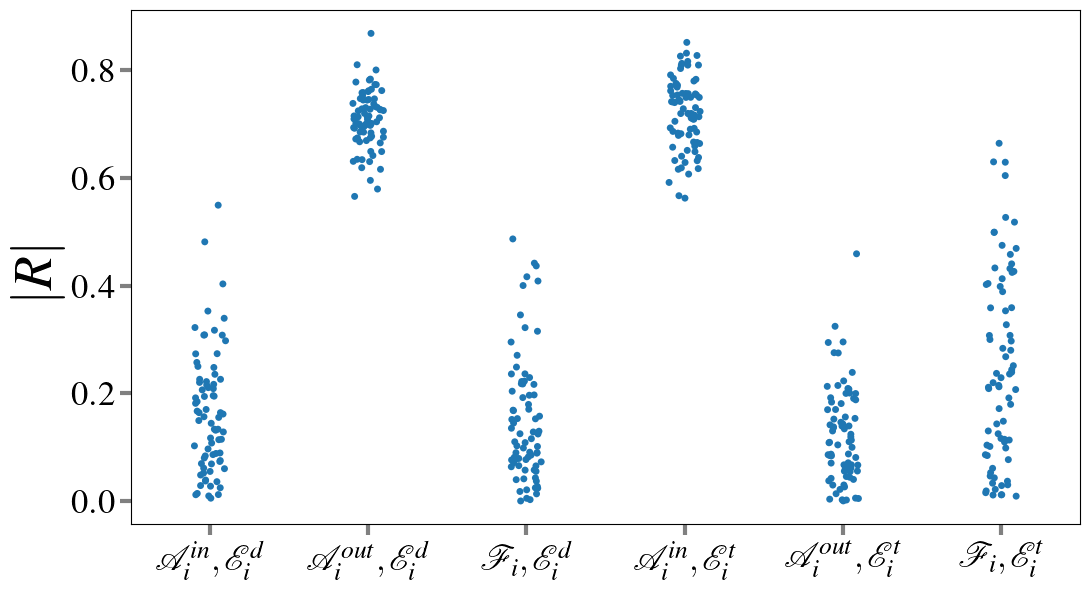

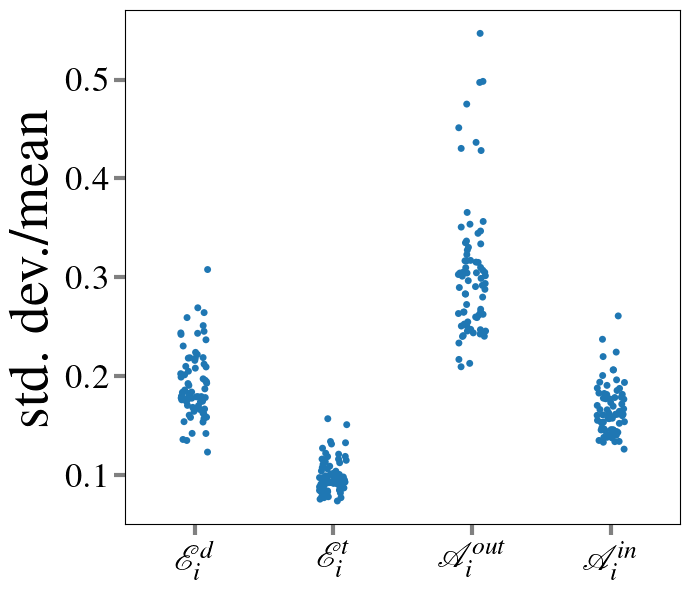

-0.09779070589126902 0.17306882209813407
0.0038976830308539777 0.15087258233847847
-0.7180582257309096 0.06564727177109637
-0.7070373628368563 0.05309393861632473
0.0961110887835136 0.17306882209813407
-0.19633552800928103 0.15087258233847847
 
0.19226379234947566 0.03427128829668732
0.0992733189345917 0.016697164605629623
0.3070251061098643 0.06825394645263795
0.1661057618199654 0.025507345146338983


In [190]:
#CV1 = np.column_stack((CorrAEn[:,0]**2,CorrAEn[:,3]**2,CorrFCEn[:,0]**2,CorrAEn[:,2]**2,CorrAEn[:,1]**2,CorrFCEn[:,1]**2))
CV1 = np.column_stack((np.abs(CorrAEn[:,0]),np.abs(CorrAEn[:,3]),\
                       np.abs(CorrFCEn[:,0]),np.abs(CorrAEn[:,2]),np.abs(CorrAEn[:,1]),np.abs(CorrFCEn[:,1])))


#fig=plt.figure(figsize=(12,5))
#plt.subplot(1,3,1)

plt.figure(figsize=(11,6))

colors = np.ones((6,3))

colors[0,:]= [31./256, 119./256, 180./256] #[220./256, 20./256, 60./256]
colors[1,:]=[31./256, 119./256, 180./256]
colors[2,:]=[31./256, 119./256, 180./256]  #[220./256, 20./256, 60./256]
colors[3,:]=[31./256, 119./256, 180./256]
colors[4,:]= [31./256, 119./256, 180./256] #[220./256, 20./256, 60./256]
colors[5,:]= [31./256, 119./256, 180./256] #[220./256, 20./256, 60./256]



YY=pd.DataFrame(data=np.column_stack((CV1[:,:6].reshape(-1),np.tile(np.arange(6),76) )),columns=['a','b'])


#seaborn.violinplot(data=YY,x="b",y="a",inner='quartile',palette=colors,width=1)
seaborn.stripplot(data=YY,x="b",y="a",palette=colors,jitter=True)


#box=plt.boxplot(CV1[:,:6],patch_artist=True,labels=[r'$\mathcal{A}_i^{in},\mathcal{E}_i^{d}$',\
#                            r'$\mathcal{A}_i^{out},\mathcal{E}_i^{d}$',\
#                            r'$ \mathcal{F}_i,\mathcal{E}_i^{d} $','$\mathcal{A}_i^{in},\mathcal{E}_i^{t}$',\
#                r'$\mathcal{A}_i^{out},\mathcal{E}_i^{t}$','$\mathcal{F}_i,\mathcal{E}_i^{t}$'],manage_ticks=True)


plt.xticks(np.arange(6),labels=[r'$\mathcal{A}_i^{in},\mathcal{E}_i^{d}$',\
                            r'$\mathcal{A}_i^{out},\mathcal{E}_i^{d}$',\
                            r'$ \mathcal{F}_i,\mathcal{E}_i^{d} $','$\mathcal{A}_i^{in},\mathcal{E}_i^{t}$',\
                r'$\mathcal{A}_i^{out},\mathcal{E}_i^{t}$','$\mathcal{F}_i,\mathcal{E}_i^{t}$'],size=25)

plt.yticks(size=25)
plt.xlabel('',size=1)


plt.ylabel(r'$|R|$',size=40)

plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

plt.tight_layout()

plt.savefig('figs/fig9a.png')

plt.figure(figsize=(7,6))

YY=np.column_stack((consistencyContInput1,consistencyContTarget1,consistencyOutDegree1,\
                                 consistencyInDegree1)) 

YY=pd.DataFrame(data=np.column_stack((YY.reshape(-1),np.tile(np.arange(4),74) )),columns=['a','b'])

#seaborn.violinplot(data=YY,x="b",y="a",inner='quartile',palette=colors,width=1)
seaborn.stripplot(data=YY,x="b",y="a",palette=colors,jitter=True)


#box=plt.boxplot(,patch_artist=True,labels=[r'$\mathcal{E}_i^{d}$',\
                    #        r'$\mathcal{E}_i^{t}$',r'$\mathcal{A}_i^{out}$',r'$\mathcal{A}_i^{in}$'],manage_ticks=True)


plt.xticks(np.arange(4),labels=[r'$\mathcal{E}_i^{d}$',\
                            r'$\mathcal{E}_i^{t}$',r'$\mathcal{A}_i^{out}$',r'$\mathcal{A}_i^{in}$'],size=25)
plt.yticks(size=25)

plt.xlabel('',size=1)
plt.ylabel(r'std. dev./mean',size=40)

plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

plt.tight_layout()


plt.savefig('figs/fig9b.png')



plt.show()

#for patch,color in zip(box['boxes'],colors):
#    patch.set_facecolor(color)

print(np.mean(CorrAEn[:,0]),np.std(CorrAEn[:,0]))
print(np.mean(CorrAEn[:,1]),np.std(CorrAEn[:,1]))
print(np.mean(CorrAEn[:,2]),np.std(CorrAEn[:,2]))
print(np.mean(CorrAEn[:,3]),np.std(CorrAEn[:,3]))
print(np.mean(CorrFCEn[:,0]),np.std(CorrAEn[:,0]))
print(np.mean(CorrFCEn[:,1]),np.std(CorrAEn[:,1]))
print(' ')
print(np.mean(consistencyContInput1),np.std(consistencyContInput1))
print(np.mean(consistencyContTarget1),np.std(consistencyContTarget1))
print(np.mean(consistencyOutDegree1),np.std(consistencyOutDegree1))
print(np.mean(consistencyInDegree1),np.std(consistencyInDegree1))


# Fig 11

In [191]:
ContInputEnRank= np.zeros((nroi,nsbj)) #np.sum(-np.log10(ContMatrix),axis=1)
ContTargetEnRank= np.zeros((nroi,nsbj)) #np.sum(np.log10(ContMatrix),axis=0)

for n in range(nsbj):
    ContInputEnRank[:,n]=np.argsort(np.argsort(-ContInputEn[:,n]))
    ContTargetEnRank[:,n]=np.argsort(np.argsort(-ContTargetEn[:,n]))


In [193]:
coords = np.loadtxt('data/roicenters2.txt',delimiter=',')


df_region = pd.read_csv("data/regionclustinfo4.txt", sep=" ", header=None)
nodes = df_region[0].tolist()

regions = df_region[2].tolist()

region_dict = dict(zip(nodes, regions) )
region_dict

region_names = np.unique(np.array(list(region_dict.values())))
cmap = plt.cm.get_cmap('Set1')

# blue = cmap(0)[:3]
node_color=[]
#node_coord_matrix=[]


for key, value in region_dict.items():
    for i in range(len(region_names)):
        if value == region_names[i]:   
            node_color.append( cmap(i)[:3] )
            #node_coord_matrix.append( node_coord_dict[key] )

region_names_short = ['CON', 'DMN', 'DAN', 'LIM', 'VAN', 'SM','SUB', 'VIS']


55.671052631578945
21.210526315789473
64.88157894736842
1.4342105263157894


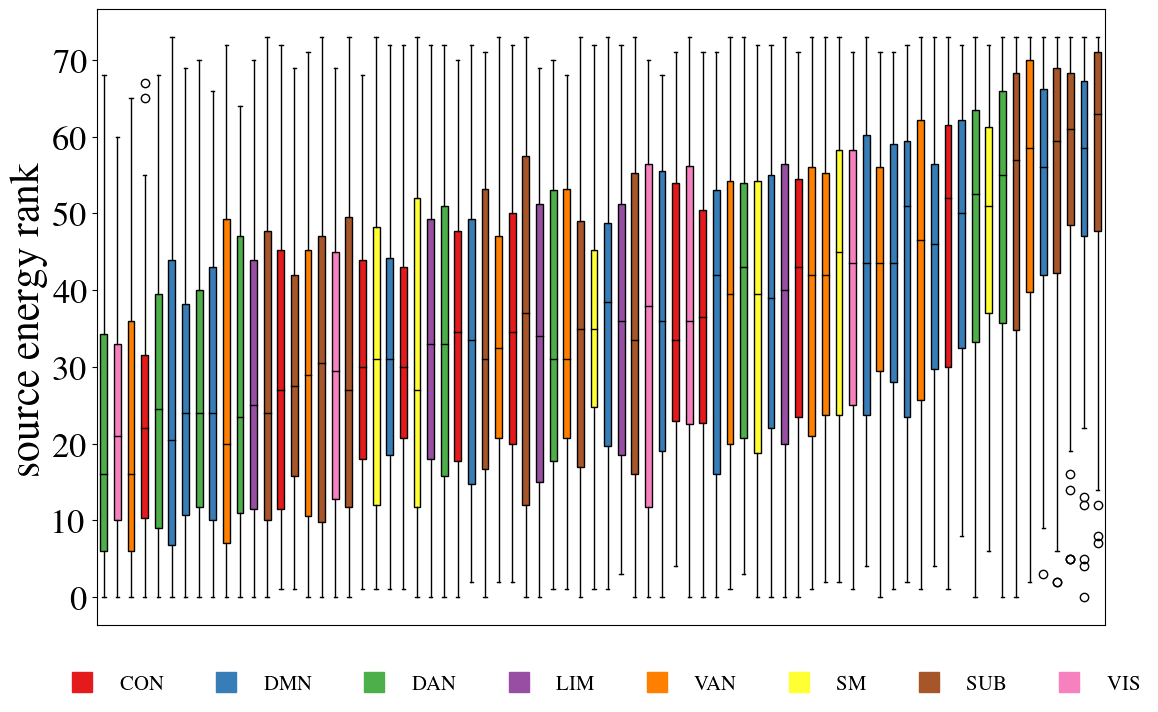

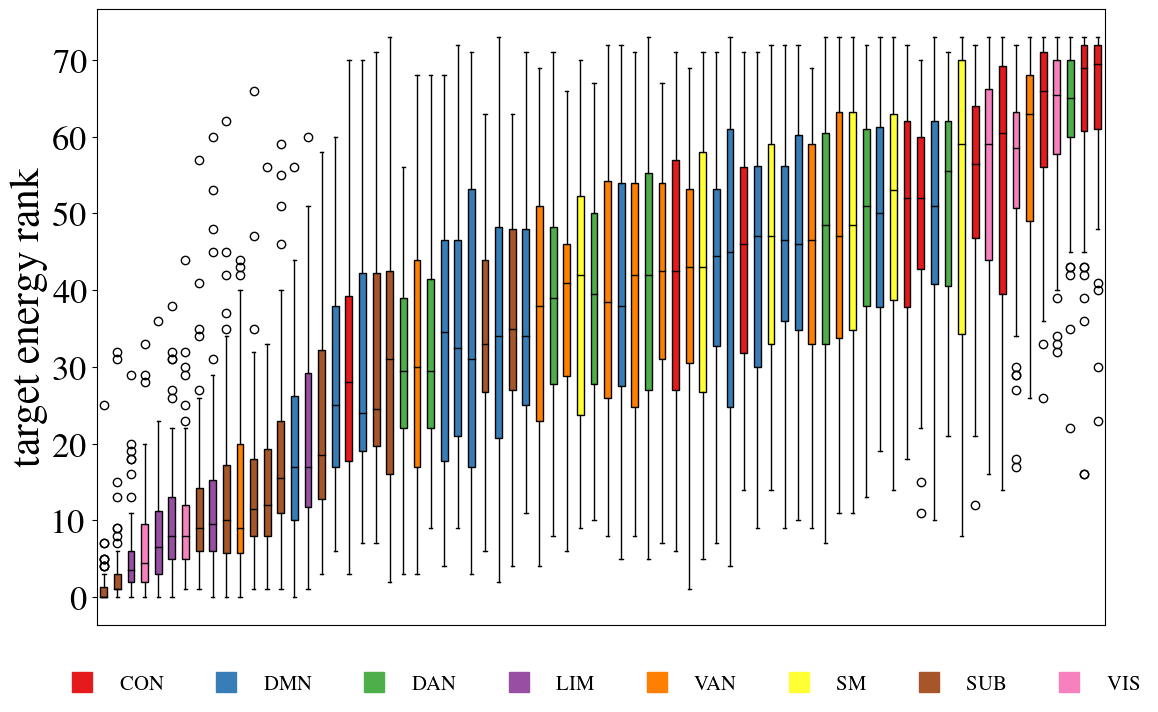

In [196]:


plt.figure(figsize=(13,8))



idx = np.argsort(np.mean(ContInputEnRank,axis=1))
nc = np.asarray(node_color)

box=plt.boxplot(ContInputEnRank[idx,:].T,patch_artist=True)


colors = color=nc[idx,:]

for patch,color in zip(box['boxes'],colors):
    patch.set_facecolor(color)

for patch in box['medians']:
    patch.set_color('black')
    
    
plt.ylabel('source energy rank',size=30)

#plt.bar(np.arange(nroi),ContInputEnRank)
plt.xticks([])
plt.yticks(size=25)

colors = []
for c in cmap.colors:
    colors.append(matplotlib.colors.to_hex(c))

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(8)]
labels = region_names_short
#legend = plt.legend(handles, labels, prop={'size': 15},loc=3, framealpha=1, frameon=False,bbox_to_anchor=(1,0.3))
legend = plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),\
                    prop={'size': 15}, framealpha=1, frameon=False,\
                    ncol=8,markerscale=2.5)


plt.savefig('figs/fig11a.png')
#plt.show()

plt.figure(figsize=(13,8))

idx = np.argsort(np.mean(ContTargetEnRank,axis=1))

box=plt.boxplot(ContTargetEnRank[idx,:].T,patch_artist=True)

colors = color=nc[idx,:]

for patch,color in zip(box['boxes'],colors):
    patch.set_facecolor(color)

for patch in box['medians']:
    patch.set_color('black')
    
plt.ylabel('target energy rank',size=30)

plt.xticks([])
plt.yticks(size=25)

colors = []
for c in cmap.colors:
    colors.append(matplotlib.colors.to_hex(c))

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(8)]
labels = region_names_short
legend = plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),\
                    prop={'size': 15}, framealpha=1, frameon=False,\
                    ncol=8,markerscale=2.5)

plt.savefig('figs/fig11b.png')

#plt.show()

idx = np.argsort(np.mean(ContInputEnRank,axis=1))
#print(np.mean(ContInputEnRank[idx,:],axis=1))
#print(np.std(ContInputEnRank[idx,:],axis=1))


#print(coords[idx[-20:],:])

idx = np.argsort(np.mean(ContTargetEnRank,axis=1))
#print(np.mean(ContTargetEnRank[idx,:],axis=1))
#print(np.std(ContTargetEnRank[idx,:],axis=1))


print(np.max(np.mean(ContInputEnRank,axis=1)))
print(np.min(np.mean(ContInputEnRank,axis=1)))
print(np.max(np.mean(ContTargetEnRank,axis=1)))
print(np.min(np.mean(ContTargetEnRank,axis=1)))


#print(coords[idx[-20:],:])

# Fig 12

Cont
Default
DorsAttn
Limbic
SalVentAttn
SomMot
Subcortical
Vis


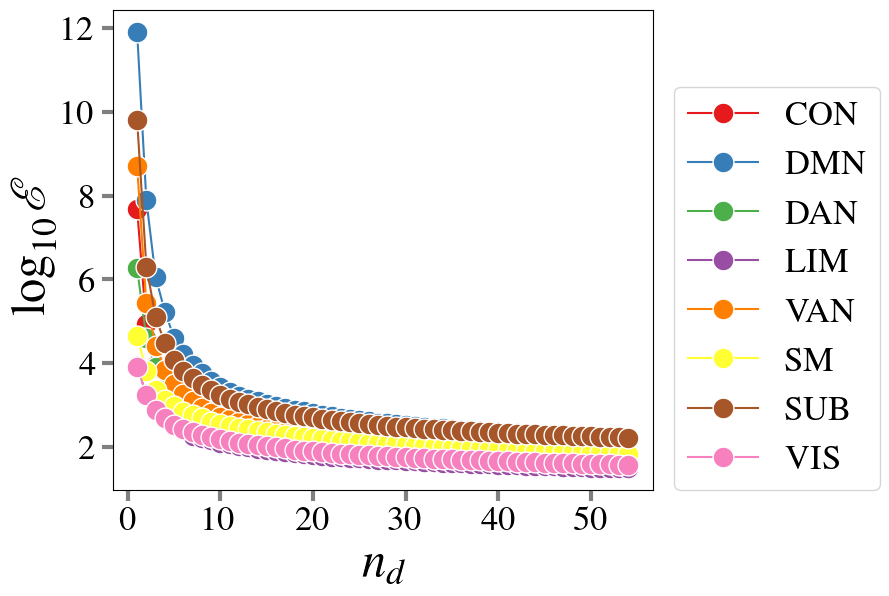

In [197]:
path = "./results/"

centrality_criteria_list = ["singlenodemin","out_degree", "pq", "ratio_degree", "page_rank","random"]


plt0 = np.zeros((len(region_list),55))
r=0


for region_name in region_list:
    
    print(region_name)
    new_path = path+region_name+"/"
        
    target_list = target_nodes(region_dict,region_name)


    centrality=region_centr_dict[region_name]  #'singlenode' #
            
                
    if centrality=="singlenode":
        f=open("./target/singleNode_energy.json")          #singleNode_nodes.json")
            
        
        data = json.load(f)
            
        df=np.asarray(data[region_name])
        df=df.T
                
        plt0[r,:]=np.flip(np.mean(np.log10(df[-55:,:]),axis=1))
            
    else:
        df = pd.read_csv(new_path+centrality+".csv")
        
        for nc in range(55):
            plt0[r,nc]=np.mean(np.log10(np.array(df.iloc[-nc,1:].tolist())))
            
        
    r=r+1
    
    
cmap = plt.cm.get_cmap('Set1')
plt.figure(figsize=(9,6))

r=0
for region_name in region_list:
    #print(np.shape(emin_net[region_name]))

    plt.plot(np.arange(1,55),plt0[r,1:],marker='o', markeredgecolor='white', markersize=15,label=region_names_short[r],c=cmap(r)[:3])
    
 
    r=r+1
    
#plt.xlim(1,6)
#plt.ylim(0,3.5)
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel(r'$n_d$',size=35)
plt.ylabel(r'$\log_{10}\mathcal{E}$',size=35)

plt.legend(loc=(1.04, 0),prop={'size': 25})
plt.tight_layout()
plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)


plt.savefig('figs/fig12a.png')

Cont
Default
DorsAttn
Limbic
SalVentAttn
SomMot
Subcortical
Vis


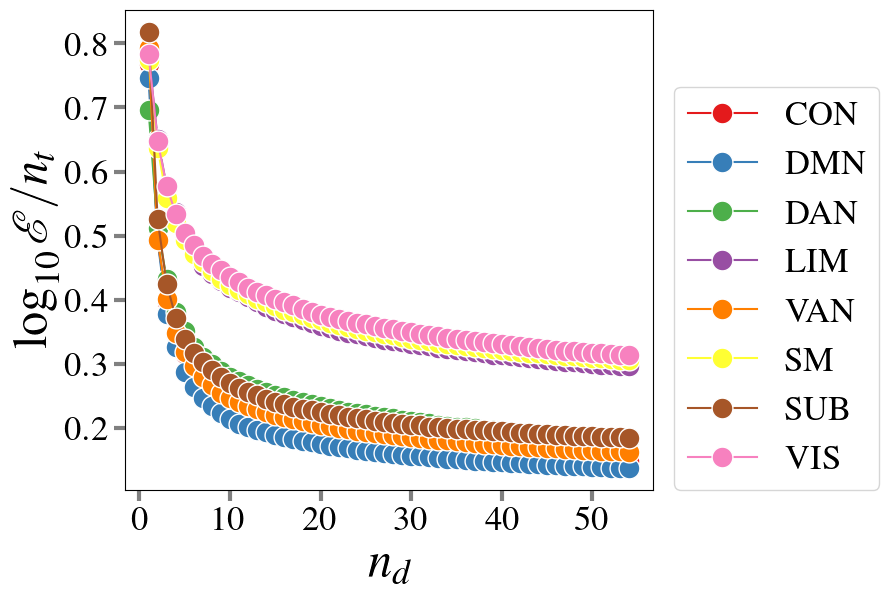

In [199]:
path = "./results/"

centrality_criteria_list = ["singlenodemin","out_degree", "pq", "ratio_degree", "page_rank","random"]


plt0 = np.zeros((len(region_list),55))
r=0


for region_name in region_list:
    
    print(region_name)
    new_path = path+region_name+"/"
        
    target_list = target_nodes(region_dict,region_name)


    #centrality='singlenode' 
    centrality=region_centr_dict[region_name] 
            
                
    if centrality=="singlenode":
        f=open("./target/singleNode_energy.json")          #singleNode_nodes.json")
            
        
        data = json.load(f)
            
        df=np.asarray(data[region_name])
        df=df.T
                
        plt0[r,:]=np.flip(np.mean(np.log10(df[-55:,:]),axis=1))
            
    else:
        df = pd.read_csv(new_path+centrality+".csv")
        
        for nc in range(55):
            plt0[r,nc]=np.mean(np.log10(np.array(df.iloc[-nc,1:].tolist())))
            
    
        
    r=r+1

nt=np.asarray([10,16,9,5,11,6,12,5])
nt=np.repeat(nt,55)
nt=np.reshape(nt,(8,55))

plt0=np.divide(plt0,nt)
    
cmap = plt.cm.get_cmap('Set1')
plt.figure(figsize=(9,6))

r=0
for region_name in region_list:
    #print(np.shape(emin_net[region_name]))

    plt.plot(np.arange(1,55),plt0[r,1:],marker='o', markeredgecolor='white', markersize=15,label=region_names_short[r],c=cmap(r)[:3])
    
 
    r=r+1
    
#plt.xlim(1,6)
#plt.ylim(0,3.5)
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel(r'$n_d$',size=35)
plt.ylabel(r'$\log_{10}\mathcal{E}/n_t$',size=35)

plt.legend(loc=(1.04, 0),prop={'size': 25})
plt.tight_layout()
plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)


plt.savefig('figs/fig12b.png')

# Fig 14

In [200]:
np.random.seed(0)

acc = 10**np.linspace(-2,0,74)
np.random.shuffle(acc)


In [201]:
seed_list = list(range(100,110,1))
seed_list

[100, 101, 102, 103, 104, 105, 106, 107, 108, 109]

In [202]:
##################################   RELEVANT CODE   ################################################

In [203]:
if os.path.exists('results/centr_sub_numContr_evalsW_acc.mat'): 
    print('done')
else:
    mat_dict = {}

    for centrality in ["out_degree", "pq", "ratio_degree", "page_rank","modified_pq"]:
        print(centrality)
        all_sub_eval_arr = [] # collection of arr of 23 subjects

        for i in range(len(mat_files)):
            A = loadmat(fpath+mat_files[i])["A_sparse"]
            A = A.T
            num_control_nodes, single_sub_eval_arr = Nodes_eval_relation(A, centrality,acc=acc)
            # single_sub_eval_arr: 74 x 74 matrix, each row represents eigen values at from 
            # highest(ND=74) to lowest(ND=71) num of control nodes

            # here we append the 2x2 matrix in a list
            all_sub_eval_arr.append(single_sub_eval_arr)
        all_sub_eval_arr = np.array(all_sub_eval_arr) # dim: 23x(74x74) 
        mat_dict[centrality] = all_sub_eval_arr

    savemat("/results/centr_sub_numContr_evalsW_acc.mat", mat_dict)

done


In [204]:
seed_list = list(range(100, 100+10, 1))
seed_list

[100, 101, 102, 103, 104, 105, 106, 107, 108, 109]

In [205]:
if os.path.exists('results/Random_sub_numContr_evalsW_fixedSeed_acc.mat'): 
    print('done')
else:

    centrality="random"
    random_dict = {}

    for i in range(len(mat_files)):
        print(mat_files[i][:-4])
    
        single_sub_eval_arr_list = []
    
        A = loadmat(fpath+mat_files[i])["A_sparse"]
        A = A.T

        for j in seed_list:
    
            num_control_nodes, single_sub_eval_arr = Nodes_eval_relation(A, centrality, seed=j,acc=acc)
            #print(num_control_nodes)
            #print(single_sub_eval_arr)
            # single_sub_eval_arr: 74 x 74 matrix, each row represents eigen values at from 
            # highest(ND=74) to lowest(ND=71) num of control nodes
            single_sub_eval_arr_list.append(single_sub_eval_arr)
        random_dict[mat_files[i][:-4]] = np.array(single_sub_eval_arr_list)
    
    #nsbj x 10 x 74 x 74

    savemat("results/Random_sub_numContr_evalsW_fixedSeed_acc.mat", random_dict)

done


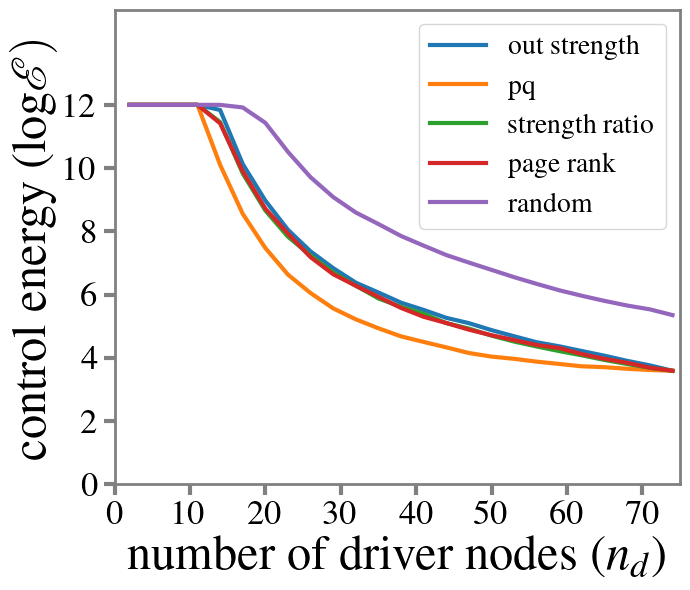

In [206]:
rc('axes',edgecolor='gray',linewidth=2)
nregions=74

Num_control_nodes = np.array(list(range(nregions, 0, -1)))

energy_type="min"

#fig, ax1=plt.figure(figsize=(12,7))
fig, ax1 = plt.subplots(figsize=(7,6))
min_ylim = []

rand_evalFile = "results/Random_sub_numContr_evalsW_fixedSeed_acc.mat"
centr_evalFile  = "results/centr_sub_numContr_evalsW_acc.mat"

cent_names = {'out_degree': 'out strength', 'modified_pq': 'pq', 'ratio_degree': 'strength ratio','page_rank': 'page rank','random': 'random'}

for centrality in ['out_degree', 'modified_pq', 'ratio_degree', 'page_rank', 'random']:
    if centrality=="random":
        
        rand_energy, rand_std, max_energy, min_energy = random_stat(path=rand_evalFile,
                                            energy=energy_type)
        ax1.plot(Num_control_nodes[range(0,74,3)], np.log10(rand_energy)[range(0,74,3)], '-',\
                 label=cent_names[centrality],linewidth=3) # marker='o', markeredgecolor='white',markersize=15
        #ax1.fill_between(Num_control_nodes, np.log10(rand_energy)-rand_std, np.log10(rand_energy)+rand_std,alpha=0.5)
        #ax1.fill_between(Num_control_nodes, np.log10(rand_energy-rand_std), np.log10(rand_energy+rand_std),alpha=0.5)
        #ax1.fill_between(Num_control_nodes, np.log10(min_energy), np.log10(max_energy),alpha=0.5)
        min_ylim.append(min(rand_energy))
        
    else:    
        matrix_3d = loadmat(centr_evalFile)[centrality]
        
        nSubjects = np.shape(matrix_3d)[0]
        N = np.shape(matrix_3d)[1]

        energy = []
        for i in range(nSubjects):
            matrix_2d = matrix_3d[i]
            
            if energy_type=="min":    
                min_evals = np.min(matrix_2d, axis=1)
                energy.append( compute_e_min(min_evals) )
            elif energy_type=="median":
                energy.append( np.median(compute_e_min(matrix_2d) , axis=1) )
                #energy.append( np.median(matrix_2d**-1 , axis=1) )

        energy = np.array(energy).T  # 74X76 matrix   
        #print(energy.shape)
        avg_energy = np.median(np.log10(energy), axis=1)
        

        ax1.plot(Num_control_nodes[range(0,74,3)], avg_energy[range(0,74,3)], '-', \
                 label=cent_names[centrality],linewidth=3) #marker='o', markeredgecolor='white', markersize=15
        min_ylim.append(min(avg_energy))
        

ax1.legend(loc="best", prop={"size":20})

ax1.set_xlabel(r"number of driver nodes ($n_d$)", size=35)
ax1.set_ylabel(r"control energy (log$\mathcal{E})$", size=35)
ax1.set_xlim([1,75])
ax1.set_ylim([0,15])
ax1.set_xticks(range(0, 75, 10))
ax1.set_xticklabels(range(0, 75, 10),size=25)
ax1.set_yticks(range(0, 13, 2))
ax1.set_yticklabels(range(0, 13, 2),size=25)
ax1.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

plt.tight_layout()

plt.savefig("./figs/fig14a.png" % {"et": energy_type}, facecolor="white", bbox_inches="tight")


plt.show()    
    



[ 1  2  3  4  5  9 10 11 12 13 17 18 19 20 21]
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


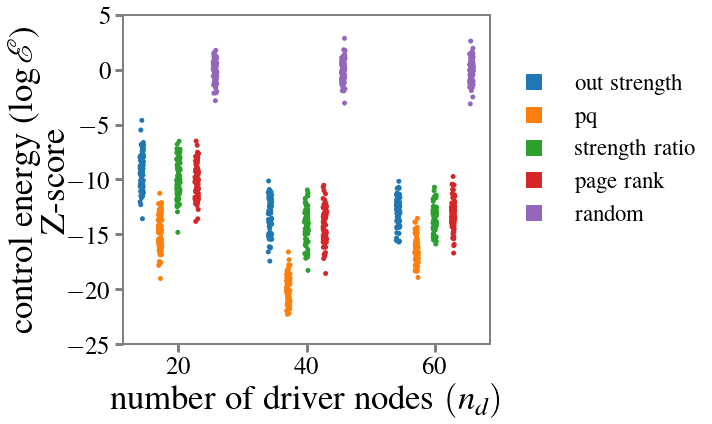

In [72]:
nc = np.asarray([20,40,60])

EG = np.zeros((len(nc),5,76))


rand_evalFile = "results/Random_sub_numContr_evalsW_fixedSeed_acc.mat"
centr_evalFile  = "results/centr_sub_numContr_evalsW_acc.mat"


subject_names = [mat_files[i][:-4] for i in range(len(mat_files))]

a=0;


for centrality in ['out_degree', 'modified_pq', 'ratio_degree', 'page_rank', 'random']:
    
    if centrality=="random":
        path=rand_evalFile
        avg_min_energy_23Sub = []
        
        for i in range(len(subject_names)):
            matrix3d = loadmat(path)[subject_names[i]]

            avg_min_energy_realizations = []
            for j in range(matrix3d.shape[0]):#10 realizations
                avg_min_energy_realizations.append(compute_e_min( list( np.min(matrix3d[j], axis=1) ) ) )
               
            avg_min_energy_realizations = np.mean(np.array(avg_min_energy_realizations) ,axis=0) # taking avg over 10 realizations
            
            avg_min_energy_23Sub.append(list(avg_min_energy_realizations))
                
                
        EG[:,a,:]=(np.matrix(avg_min_energy_23Sub)[:,74-nc]).T
        a=a+1     
        
                
    else:    
        matrix_3d = loadmat(centr_evalFile)[centrality]
        
        nSubjects = np.shape(matrix_3d)[0]
        N = np.shape(matrix_3d)[1]

        energy = []
        for i in range(nSubjects):
            matrix_2d = matrix_3d[i]
            
            min_evals = np.min(matrix_2d, axis=1)
            energy.append( compute_e_min(min_evals) )
           
        energy = np.array(energy).T  # 74X76 matrix   
       
        EG[:,a,:]=energy[74-nc,:]
        a=a+1 


EG=np.log10(EG)
        
for c in range(3):
    EG[c,:,:] = (EG[c,:,:]-np.mean(EG[c,-1,:]))/np.std(EG[c,-1,:])
    
        
base = 0
pos = list(range(1,6))
for q in range(2):
    base = base + 8
    pos = pos + list(range(base+1,base+5+1))

pos = np.array(pos)
print(pos)


fig,ax=plt.subplots(figsize=(10,6))

XX=np.reshape(EG,(3*5,76)).T 

YY=-30*np.ones((76,3*7))

YY[:,0:5]=XX[:,0:5]
YY[:,7:12]=XX[:,5:10]
YY[:,14:19]=XX[:,10:15]


colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

colors7=colors[:7]



#plt.violinplot(XX,colors=colors)



YY=pd.DataFrame(data=np.column_stack((YY.reshape(-1),np.tile(np.arange(21),76),\
                                      np.tile(np.repeat(np.arange(3),7),76))),columns=['a','b','c'])

#print(XX)

colors = colors * 3


print(colors)


#seaborn.violinplot(data=YY,x="b",y="a",inner='quartile',palette=colors7,width=1.5)
seaborn.stripplot(data=YY,x="b",y="a",palette=colors7,jitter=True)

plt.ylim(-25,5)
plt.xlim(-1,19)

#box=plt.boxplot(np.reshape(EG,(3*5,76)).T,positions=pos,patch_artist=True,showfliers=False)



plt.yticks(size=15)

colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

'''
colors=colors[:5]

colors = colors * 3

for patch,color in zip(box['boxes'],colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

    
for patch in box['medians']:
    patch.set_color('black')
'''

plt.xticks(range(2,20,7),labels=nc,size=25)   
plt.xlabel(r'number of driver nodes $(n_d)$',size=35)
plt.ylabel(r'control energy ($\log\mathcal{E}$)\\ \  ${}_{} \qquad \quad $\ Z-score',size=35)
#plt.ylabel(r'control energy ($\log\mathcal{E}$) \n  Z-score',size=35)
plt.yticks(size=25)   

ax.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)


f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(5)]
labels = cent_names.values()
legend = plt.legend(handles, labels, markerscale=2.5, prop={'size': 23},loc=3, framealpha=1, frameon=False,bbox_to_anchor=(1,0.3))


plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

    
#plt.ylabel(r'$\log_{10}(\mathcal{E})/n_t$',size=25)
    
plt.tight_layout()
plt.savefig("./figs/fig14b.png" % {"et": energy_type}, facecolor="white", bbox_inches="tight")

plt.show()    

# Fig 15

In [207]:
seed_list = list(range(100,110,1))
seed_list

[100, 101, 102, 103, 104, 105, 106, 107, 108, 109]

In [208]:
if os.path.exists('results/centr_sub_numContr_evalsW_fc.mat'): 
    print('done')
else:
    mat_dict = {}

    for centrality in ["out_degree", "pq", "ratio_degree", "page_rank","modified_pq"]:
        print(centrality)
        all_sub_eval_arr = [] # collection of arr of 23 subjects

        for i in range(len(mat_files)):
            A = loadmat(fpath+mat_files[i])["A_sparse"]
            A = A.T
            FC = loadmat(fpath+mat_files[i])["FC"]
            FC = FC-np.diag(np.diag(FC))
            efc,wfc = np.linalg.eig(FC)
            FC=-1.1*np.max(efc)*np.eye(np.shape(FC)[0])+FC
             
            num_control_nodes, single_sub_eval_arr = Nodes_eval_relation(A, centrality,adj_rank=FC)
            # single_sub_eval_arr: 74 x 74 matrix, each row represents eigen values at from 
            # highest(ND=74) to lowest(ND=71) num of control nodes

            # here we append the 2x2 matrix in a list
            all_sub_eval_arr.append(single_sub_eval_arr)
        all_sub_eval_arr = np.array(all_sub_eval_arr) # dim: 23x(74x74) 
        mat_dict[centrality] = all_sub_eval_arr

    savemat("/home/michele/karan/final_results/centr_sub_numContr_evalsW_fc.mat", mat_dict)

done


In [209]:
seed_list = list(range(100, 100+10, 1))
seed_list

[100, 101, 102, 103, 104, 105, 106, 107, 108, 109]

In [212]:
if os.path.exists('results/Random_sub_numContr_evalsW_fixedSeed_fc.mat'): 
    print('done')
else:

    centrality="random"
    random_dict = {}

    for i in range(len(mat_files)):
        print(mat_files[i][:-4])
    
        single_sub_eval_arr_list = []
        A = loadmat(fpath+mat_files[i])["A_sparse"]    
        FC = loadmat(fpath+mat_files[i])["FC"]
        #A = A.T
        FC = FC - np.diag(np.diag(A))
        efc,wfc = np.linalg.eig(FC)
        FC = -1.1*np.max(efc)*np.eye(np.shape(FC)[0])+FC

        
        for j in seed_list:
    
            num_control_nodes, single_sub_eval_arr = Nodes_eval_relation(A, centrality, seed=j,adj_rank=FC)
            #print(num_control_nodes)
            #print(single_sub_eval_arr)
            # single_sub_eval_arr: 74 x 74 matrix, each row represents eigen values at from 
            # highest(ND=74) to lowest(ND=71) num of control nodes
            single_sub_eval_arr_list.append(single_sub_eval_arr)
        random_dict[mat_files[i][:-4]] = np.array(single_sub_eval_arr_list)
    
    #nsbj x 10 x 74 x 74

    savemat("results/Random_sub_numContr_evalsW_fixedSeed_fc.mat", random_dict)

done


In [ ]:
target_list = list(set(range(1,74+1, 1))) #- set(control_nodes))

In [215]:
use_target_as_control=True
use_sbj1= 0
use_sbj2= 76
use_ctr = 5

target_list = list(set(range(1,74+1, 1))) #- set(control_nodes))
seed = 123
np.random.seed(seed)
np.random.shuffle(target_list)


#target_list = target_list[:30]

#target_list = (list(sorted_d0.keys()))

#target_list = nodes_limbic

emin = {}


if os.path.exists('results/target_size_fc.mat'): 
    print('done')
    stop

for centrality in ["out_degree", "ratio_degree", "pq", "page_rank"]:
    all_emin_array = []# 230 lists
    

    for i in range(use_sbj1,use_sbj2):
        A = loadmat(fpath+mat_files[i])["A_sparse"]
        A = A.T
        FC = loadmat(fpath+mat_files[i])["FC"]
        FC = FC-np.diag(np.diag(FC))
        efc,wfc = np.linalg.eig(FC)
        FC=-1.1*np.max(efc)*np.eye(np.shape(FC)[0])+FC  
    
        
        if centrality=="pq":
            sorted_d = rank_pq(FC)
        elif centrality=="out_degree":
            sorted_d = rank_Degree(FC,rankorder='decreasing') # A should be orginal matrix
        elif centrality=="ratio_degree":
            sorted_d = rank_weight_OutbyIn_Degree(FC)
        elif centrality=="page_rank":
            sorted_d = rank_pageRank(FC)    
      
        control_nodes = list(sorted_d.keys())

        if(use_target_as_control==False):
            for t in target_list:
                control_nodes.remove(t)

        control_nodes = control_nodes[:use_ctr]
            
        min_evals_W=[]
        
        target_list1 = deepcopy(target_list)
        
        # vary the number of nodes in target list
        while len(target_list1)!=0:  
            #Num_control_nodes.append(len(control_nodes))
            
            ##for t in target_list1:
            ###    if t in control_nodes:
            ###        control_nodes.remove(t)
            ###control_nodes = control_nodes[:10]

            
            C = compute_C(N, target_list1)# output target matrix

            # compute B 
            # remember to sort the control nodes before constructing the input matrix B
            B = compute_B(N, sorted(control_nodes) )

            # check Kalman rank    
            d = target_controllability_matrix(A.T, B, C)
            rank_d = np.linalg.matrix_rank(d, tol=1E-50).item(0) # Full rank matrix 
            if rank_d!=len(target_list1):
                print("rank_d != S for Nd = ",B.shape[1])
                continue

            # compute W
            W = solve_continuous_lyapunov(A.T, -np.matmul(B, B.T)) 

            W_c = np.matmul(C, np.matmul(W, C.T))

            # compute  e_min if possible
            min_evals_W.append( min(np.linalg.eigvals(W_c)) )

            # delete the control node which has lowest out degree.
            del target_list1[-1]

            
        all_emin_array.append( compute_e_min(min_evals_W) )

    #avg_emin = np.mean(np.array(all_emin_array), axis=0)
    
    emin[centrality]=np.array(all_emin_array)
  


 

seed_list = list(range(100,110,1))

## random    
for centrality in ["random"]:
    #all_emin_array = []# 230 lists

    
    all_min_array = []
    all_max_array = []
    all_mean_array = []
    all_stdp_array = []
    all_stdm_array = []
    
    
    for i in range(use_sbj1,use_sbj2):
        
        sbj_emin_array=[]

       
        A = loadmat(fpath+mat_files[i])["A_sparse"].T
        N = len(A)
    
        for seed in seed_list:
            
            np.random.seed(seed)
            control_nodes = list(range(1,N+1))
            np.random.shuffle(control_nodes)
            
            
            if(use_target_as_control==False):
                for t in target_list:
                    control_nodes.remove(t)
                
            control_nodes = control_nodes[:use_ctr]
       
            min_evals_W=[]
        
            target_list1 = deepcopy(target_list)
        
            # vary the number of nodes in target list
            while len(target_list1)!=0:  
                
                ##for t in target_list1:
                ##    if t in control_nodes:
                ##        control_nodes.remove(t)
                ##control_nodes = control_nodes[:10]
                
                #Num_control_nodes.append(len(control_nodes))
                C = compute_C(N, target_list1)# output target matrix

                # compute B 
                # remember to sort the control nodes before constructing the input matrix B
                B = compute_B(N, sorted(control_nodes) )

                # check Kalman rank    
                d = target_controllability_matrix(A.T, B, C)
                rank_d = np.linalg.matrix_rank(d, tol=1E-50).item(0) # Full rank matrix 
                if rank_d!=len(target_list1):
                    print("rank_d != S for Nd = ",B.shape[1])
                    continue

                # compute W
                W = solve_continuous_lyapunov(A.T, -np.matmul(B, B.T)) 

                W_c = np.matmul(C, np.matmul(W, C.T))

                # compute  e_min if possible
                min_evals_W.append( min(np.linalg.eigvals(W_c)) )

                # delete the control node which has lowest out degree.
                del target_list1[-1]

            
            sbj_emin_array.append(compute_e_min(min_evals_W) )

        sbj_min_array=np.min(np.array(sbj_emin_array), axis=0)
        sbj_max_array=np.max(np.array(sbj_emin_array), axis=0)
        sbj_mean_array=np.mean(np.array(sbj_emin_array), axis=0)
        sbj_stdp_array=np.mean(np.array(sbj_emin_array), axis=0)+np.std(np.array(sbj_emin_array), axis=0)
        sbj_stdm_array=np.mean(np.array(sbj_emin_array), axis=0)-np.std(np.array(sbj_emin_array), axis=0)
        
        
        all_min_array.append(sbj_min_array)
        all_max_array.append(sbj_max_array)
        all_mean_array.append(sbj_mean_array)
        all_stdp_array.append(sbj_stdp_array)
        all_stdm_array.append(sbj_stdm_array)
            
        
    #avg_emin_min = np.mean(np.array(all_min_array), axis=0)
    #avg_emin_max = np.mean(np.array(all_max_array), axis=0)
    #avg_emin_mean = np.mean(np.array(all_mean_array), axis=0)
    #avg_emin_stdp = np.mean(np.array(all_stdp_array), axis=0)
    #avg_emin_stdm = np.mean(np.array(all_stdm_array), axis=0)
        
        
    #emin['random mean']=avg_emin_mean
    #emin['random min']=avg_emin_min
    #emin['random max']=avg_emin_max
    #emin['random mean+std']=avg_emin_stdp
    #emin['random mean-std']=avg_emin_stdm
   
    emin['random mean']=np.array(all_mean_array)
    emin['random min']=np.array(all_min_array)
    emin['random max']=np.array(all_max_array)
    emin['random mean+std']=np.array(all_stdp_array)
    emin['random mean-std']=np.array(all_stdm_array)
   

savemat('results/target_size_fc.mat',emin)


done


NameError: name 'stop' is not defined

                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
centrality 58.5170 3.0000 225.0000 0.0000

     Contrast    A    B  Paired  Parametric          T   dof alternative  \
0  centrality  0.0  1.0    True        True   5.722710  75.0        less   
1  centrality  0.0  2.0    True        True   4.757452  75.0        less   
2  centrality  0.0  3.0    True        True  11.108512  75.0        less   
3  centrality  1.0  2.0    True        True  -0.902168  75.0        less   
4  centrality  1.0  3.0    True        True   8.187744  75.0        less   
5  centrality  2.0  3.0    True        True   9.059773  75.0        less   

      p-unc  p-corr p-adjust       BF10    hedges  
0  1.000000     1.0     bonf  7.462e-06  0.808017  
1  0.999995     1.0     bonf        0.0  0.684492  
2  1.000000     1.0     bonf  1.422e-15  1.938630  
3  0.184928     1.0     bonf      0.373 -0.124842  
4  1.000000     1.0     bonf  3.034e-10  1.182602  
5  1

/home/michele/.local/lib/python3.9/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/home/michele/.local/lib/python3.9/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/home/michele/.local/lib/python3.9/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


     Contrast    A    B  Paired  Parametric         T   dof alternative  \
0  centrality  0.0  1.0    True        True  0.033535  75.0        less   
1  centrality  0.0  2.0    True        True  1.554770  75.0        less   
2  centrality  0.0  3.0    True        True  1.298182  75.0        less   
3  centrality  1.0  2.0    True        True  1.673700  75.0        less   
4  centrality  1.0  3.0    True        True  1.414752  75.0        less   
5  centrality  2.0  3.0    True        True -0.140397  75.0        less   

      p-unc  p-corr p-adjust   BF10    hedges  
0  0.513332     1.0     bonf  0.253  0.005153  
1  0.937895     1.0     bonf  0.797  0.243405  
2  0.900899     1.0     bonf  0.565  0.221869  
3  0.950822     1.0     bonf  0.954  0.248860  
4  0.919360     1.0     bonf  0.656  0.226118  
5  0.444361     1.0     bonf  0.255 -0.018494  
[ 1  2  3  4  8  9 10 11 15 16 17 18]


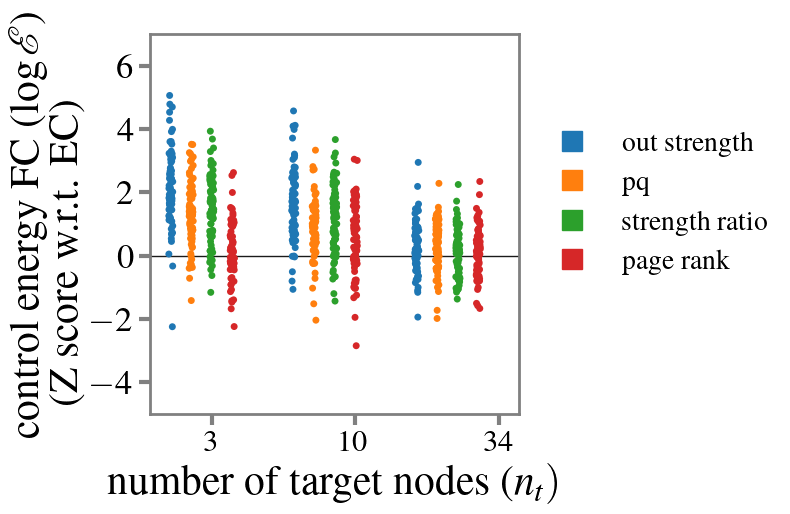

In [219]:
from scipy.stats import ttest_ind

emin=loadmat('results/target_size.mat')
emin2=loadmat('results/target_size_fc.mat')


nc = np.asarray([3,10,34])

EG = np.zeros((len(nc),4,76))

a=0

for centrality in ['out_degree', 'pq', 'ratio_degree', 'page_rank']:
             
    EG[:,a,:]=np.log10((emin2[centrality][:,74-nc]).T)-np.log10((emin[centrality][:,74-nc]).T)
    a=a+1

a=0;

for centrality in ['out_degree', 'pq', 'ratio_degree', 'page_rank']:
    for c in range(len(nc)):    
        EG[c,a,:] = EG[c,a,:]/np.std(np.log10((emin[centrality][:,74-nc[c]]).T))  
    a=a+1
    
#EG=np.log10(EG)
        
    


for l in range(len(nc)):
        
    eg  = np.zeros((76*4,3))

    c=0

    for k in range(4):
        for n in range(76):
            eg[c,0]=n
            eg[c,1]=k
            eg[c,2]=EG[l,k,n]

            c=c+1

    eg1 = pd.DataFrame(eg,columns = ['subject','centrality','energy'])


    model = AnovaRM(eg1,'energy','subject',within=['centrality'])

        
    res = model.fit()

    print(res)

    pg.rm_anova(dv='energy', within=['centrality'], subject='subject', data=eg1)


    # Optional post-hoc tests
    pht = pg.pairwise_ttests(dv='energy', within=['centrality'], subject='subject', data=eg1,alternative='less',padjust='bonf')

    print(pht)



base = 0
pos = list(range(1,5))
for q in range(2):
    base = base + 7
    pos = pos + list(range(base+1,base+4+1))

pos = np.array(pos)
print(pos)

plt.figure(figsize=(8,5))
      
plt.hlines(0,-1,17,lw=1,color='k')

    
XX=np.reshape(EG,(3*4,76)).T 

YY=-10*np.ones((76,3*6))
YY[:,0:4]=XX[:,0:4]
YY[:,6:10]=XX[:,4:8]
YY[:,12:16]=XX[:,8:12]

colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
colors7=colors[:6]

YY=pd.DataFrame(data=np.column_stack((YY.reshape(-1),np.tile(np.arange(18),76),\
                                      np.tile(np.repeat(np.arange(3),6),76))),columns=['a','b','c'])

colors7 = colors7 * 3

#seaborn.violinplot(data=YY,x="b",y="a",inner='quartile',palette=colors7,width=1.5)
seaborn.stripplot(data=YY,x="b",y="a",palette=colors7,jitter=True)

    
'''  
        
box=plt.boxplot(np.reshape(EG,(3*5,76)).T,positions=pos,patch_artist=True, showfliers=False)
'''

plt.yticks(size=25)

'''
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

colors=colors[:5]

colors = colors * 3

for patch,color in zip(box['boxes'],colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

    
for patch in box['medians']:
    patch.set_color('black')
'''

plt.xlim(-1,17)
plt.ylim(-5,7)
plt.xticks(range(2,20,7),labels=nc,size=22)   
plt.xlabel(r'number of target nodes ($n_t)$',size=30)
plt.ylabel(r'control energy FC ($\log\mathcal{E}$) \\ ${}_{}\quad$ (Z score w.r.t. EC)',size=30)

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(4)]
labels = cent_names.values()
legend = plt.legend(handles, labels, markerscale=2.5, prop={'size': 20},loc=3, framealpha=1, frameon=False,bbox_to_anchor=(1,0.3))

#plt.ylabel(r'$\log_{10}(\mathcal{E})/n_t$',size=25)
plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

    
plt.tight_layout()
plt.savefig("figs/fig15b.png" % {"et": energy_type}, facecolor="white", bbox_inches="tight")

plt.show()    



In [220]:
if os.path.exists("results/over_ec_fc.mat"):
    print('done')
else:
    mat_dict = {}

    for centrality in ["out_degree", "pq", "ratio_degree", "page_rank"]:
        all_sub_eval_arr = [] # collection of arr of 23 subjects

        over = np.zeros((len(mat_files),1))

        for i in range(len(mat_files)):
            print(i)
            ctrln = np.zeros((74,2))

            A = loadmat(fpath+mat_files[i])["A"]
            A = A.T
 
            FC = loadmat(fpath+mat_files[i])["FC"]
            FC = FC-np.diag(np.diag(FC))
            efc,wfc = np.linalg.eig(FC)
            FC=-1.1*np.max(efc)*np.eye(np.shape(FC)[0])+FC

            if centrality=="pq":
                sorted_d = rank_pq(A)
            elif centrality=="out_degree":
                sorted_d = rank_Degree(A,rankorder='decreasing') # A should be orginal matrix
            elif centrality=="ratio_degree":
                sorted_d = rank_weight_OutbyIn_Degree(A)
            elif centrality=="page_rank":
                sorted_d = rank_pageRank(A)
          
            control_nodes = list(sorted_d.keys())     # nodes sorted according to criterion
            ctrln[:,0]=control_nodes

            if centrality=="pq":
                sorted_d = rank_pq(FC)
            elif centrality=="out_degree":
                sorted_d = rank_Degree(FC,rankorder='decreasing') # A should be orginal matrix
            elif centrality=="ratio_degree":
                sorted_d = rank_weight_OutbyIn_Degree(FC)
            elif centrality=="page_rank":
                sorted_d = rank_pageRank(FC)
          
            control_nodes = list(sorted_d.keys())     # nodes sorted according to criterion
            ctrln[:,1]=control_nodes
              
            
            #for n in range(20):
            over[i]=len(np.intersect1d(ctrln[:10,0],ctrln[:10,1]))/10.

        print(over)
        mat_dict[centrality]=over

        savemat("results/over_ec_fc.mat", mat_dict)


done


[1 2 3 4]
[0.15131579 0.10526316 0.12631579 0.28421053]


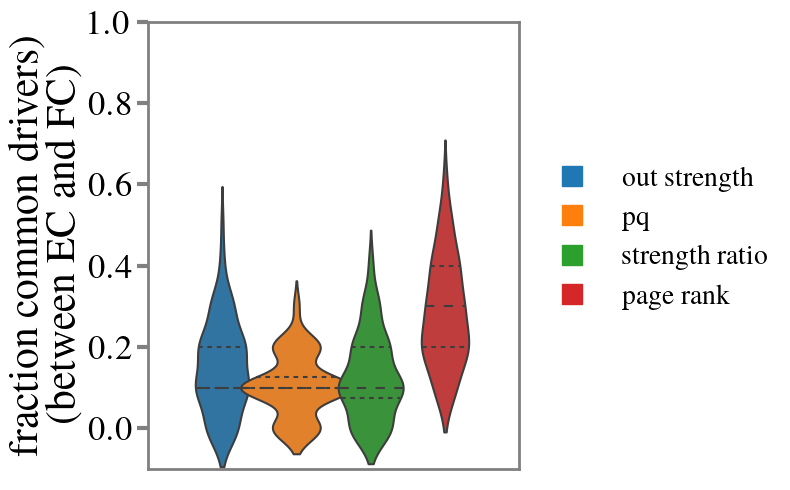

In [221]:
over = loadmat('results/over_ec_fc.mat')


from scipy.stats import ttest_ind


nc = np.asarray([3,10,34])

EG = np.zeros((1,4,76))

a=0

for centrality in ['out_degree', 'pq', 'ratio_degree', 'page_rank']:
             
    EG[0,a,:]=over[centrality][:,0]
    a=a+1

a=0;

'''
for centrality in ['out_degree', 'pq', 'ratio_degree', 'page_rank']:
    for c in range(len(nc)):    
        EG[c,a,:] = EG[c,a,:]/np.std(np.log10((emin[centrality][:,74-nc[c]]).T))  
    a=a+1
'''       
    

for l in range(1):
        
    eg  = np.zeros((76*4,3))

    c=0

    for k in range(4):
        for n in range(76):
            eg[c,0]=n
            eg[c,1]=k
            eg[c,2]=EG[l,k,n]

            c=c+1



base = 0
pos = list(range(1,5))

pos = np.array(pos)
print(pos)

plt.figure(figsize=(8,5))
      

    
XX=np.reshape(EG,(1*4,76)).T 

YY=-10*np.ones((76,1*6))
YY[:,0:4]=XX[:,0:4]
#YY[:,6:10]=XX[:,4:8]
#YY[:,12:16]=XX[:,8:12]

colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
colors7=colors[:6]

YY=pd.DataFrame(data=np.column_stack((YY.reshape(-1),np.tile(np.arange(6),76),\
                                      np.tile(np.repeat(np.arange(1),6),76))),columns=['a','b','c'])

colors7 = colors7 * 3

seaborn.violinplot(data=YY,x="b",y="a",inner='quartile',palette=colors7,width=1.5)


print(np.mean(XX,axis=0))

#seaborn.stripplot(data=YY,x="b",y="a",palette=colors7,jitter=True)

    
'''  
        
box=plt.boxplot(np.reshape(EG,(3*5,76)).T,positions=pos,patch_artist=True, showfliers=False)
'''

plt.yticks(size=25)

'''
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

colors=colors[:5]

colors = colors * 3

for patch,color in zip(box['boxes'],colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

    
for patch in box['medians']:
    patch.set_color('black')
'''

plt.xlim(-1,4)
plt.ylim(-0.1,1)
plt.xticks([]) #range(2,5,7),size=22) #,labels=nc,size=22)   
plt.ylabel(r'fraction common drivers) \\ ${}_{}\quad$ (between EC and FC)',size=30)
plt.xlabel('')
#plt.ylabel(r'control energy ($\log\mathcal{E}$) \\ ${}_{}\quad\qquad$ (Z score)',size=30)

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(4)]
labels = cent_names.values()
legend = plt.legend(handles, labels, markerscale=2.5, prop={'size': 20},loc=3, framealpha=1, frameon=False,bbox_to_anchor=(1,0.3))

#plt.ylabel(r'$\log_{10}(\mathcal{E})/n_t$',size=25)
plt.tick_params(direction='out',width=3,length=8,color='gray',top=0,right=0)

    
plt.tight_layout()
plt.savefig("figs/fig15a.png", facecolor="white", bbox_inches="tight")

plt.show()    



# Fig 16

In [224]:
if os.path.exists("results/over_noise.mat"):
    print('done')
else:
    mat_dict = {}

    for centrality in ["out_degree", "pq", "ratio_degree", "page_rank"]:
        all_sub_eval_arr = [] # collection of arr of 23 subjects

        over = np.zeros((len(mat_files),20))

        for i in range(len(mat_files)):
            print(i)            
            ctrln = np.zeros((74,20))

            A0 = loadmat(fpath+mat_files[i])["A"]
            A0s = loadmat(fpath+mat_files[i])["A_sparse"]
            A0 = A0.T
            A0s=A0s.T
            thr = loadmat(fpath+mat_files[i])["thr"]



            for n in range(20):
                nn=noise[n]
                A = A0 + np.random.normal(0,nn*np.abs(A0))
                As = A
                As[np.abs(As)<thr]=0
                As=As-np.diag(np.diag(As))+np.diag(np.diag(A0))
                #As[np.arange(74),np.arange(74)]=A0[np.arange(74),np.arange(74)]
                

                e,w=np.linalg.eig(As)

                #print(np.max(e))


                if centrality=="pq":
                        sorted_d = rank_pq(A)
                elif centrality=="out_degree":
                        sorted_d = rank_Degree(A,rankorder='decreasing') # A should be orginal matrix
                elif centrality=="ratio_degree":
                        sorted_d = rank_weight_OutbyIn_Degree(A)
                elif centrality=="page_rank":
                        sorted_d = rank_pageRank(A)    
                elif centrality=="in_degree":
                        sorted_d = rank_Degree(A,direction='in',rankorder='decreasing')    
                elif centrality=="rankdegcomm":
                        sorted_d = rank_deg_comm(A,region_dict,direction='out',rankorder='decreasing')
                elif centrality=="modified_pq":
                        sorted_d = rank_modified_pq(A,acc)

        
                control_nodes = list(sorted_d.keys())     # nodes sorted according to criterion
                ctrln[:,n]=control_nodes   

            for n in range(20):
                over[i,n]=len(np.intersect1d(ctrln[:10,0],ctrln[:10,n]))/10.
       
            #print(over)
        mat_dict[centrality]=over
        
    savemat("results/over_noise.mat", mat_dict)


done


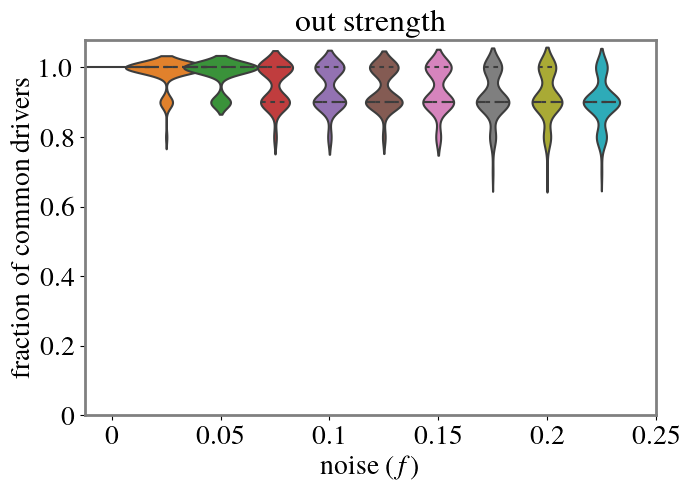

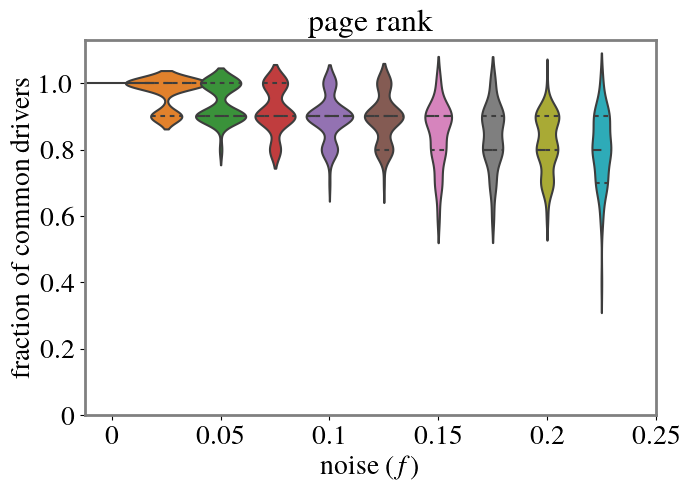

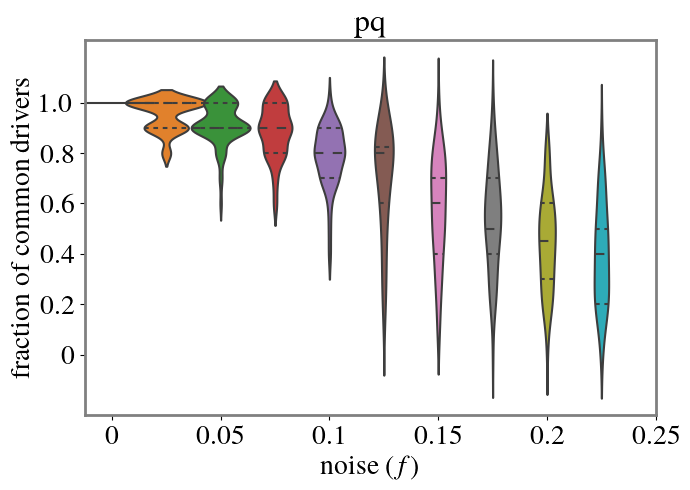

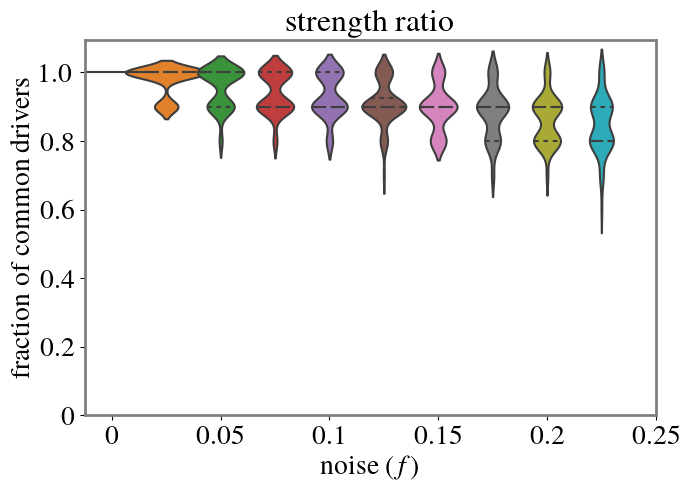

[0.    0.125 0.25  0.375]
[1.         0.97236842 0.94078947 0.91842105 0.89342105 0.89210526
 0.84342105 0.83815789 0.81578947 0.80263158 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[1.         0.98421053 0.97894737 0.94868421 0.93947368 0.93815789
 0.93421053 0.91842105 0.91578947 0.9        0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[1.         0.97763158 0.95657895 0.93947368 0.93026316 0.91184211
 0.89605263 0.88157895 0.86184211 0.84868421 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[1.         0.95394737 0.91315789 0.88026316 0.78552632 0.69342105
 0.57368421 0.53815789 0.44210526 0.39736842 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [225]:
over_noise = loadmat('results/over_noise.mat')

plt.figure(figsize=(7,5))

YY=over_noise['out_degree']
YY=YY[:,:10]
YY=pd.DataFrame(data=np.column_stack((YY.reshape(-1),np.tile(0.025*np.arange(10),76))),columns=['a','b'])

#plt.plot(0.025*np.arange(20),np.mean(YY,axis=0))
#plt.fill_between(0.025*np.arange(20),np.mean(YY,axis=0)-np.std(YY,axis=0),np.mean(YY,axis=0)+np.std(YY,axis=0),alpha=0.5)

#print(np.percentile(YY,75,axis=0))
#print(np.tile(np.arange(20),76))

#plt.plot(np.mean(over_noise['out_degree'],axis=0))
#sns.stripplot(data=YY,x="b",y="a",s=8,jitter=True)
plt.title('out strength', size=23)
ax=sns.violinplot(data=YY,x="b",y="a",inner='quartile',width=1.5)
ax.set_xticks(np.arange(0,11,2))
ax.set_xticklabels([0,0.05,0.1,0.15,0.2,0.25],size=20)
ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0],size=20)
ax.set_ylabel('fraction of common drivers',size=20)
ax.set_xlabel(r'noise ($f$)',size=20)
plt.tight_layout()
plt.savefig("./figs/fig16a.png", facecolor="white", bbox_inches="tight")


plt.figure(figsize=(7,5))

YY=over_noise['page_rank']
YY=YY[:,:10]
YY=pd.DataFrame(data=np.column_stack((YY.reshape(-1),np.tile(0.025*np.arange(10),76))),columns=['a','b'])

#plt.plot(0.025*np.arange(20),np.mean(YY,axis=0))
#plt.fill_between(0.025*np.arange(20),np.mean(YY,axis=0)-np.std(YY,axis=0),np.mean(YY,axis=0)+np.std(YY,axis=0),alpha=0.5)

#print(np.percentile(YY,75,axis=0))
#print(np.tile(np.arange(20),76))

#plt.plot(np.mean(over_noise['out_degree'],axis=0))
#sns.stripplot(data=YY,x="b",y="a",s=8,jitter=True)
plt.title('page rank',size=23)
ax=sns.violinplot(data=YY,x="b",y="a",inner='quartile',width=1.5)
ax.set_xticks(np.arange(0,11,2))
ax.set_xticklabels([0,0.05,0.1,0.15,0.2,0.25],size=20)
ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0],size=20)
ax.set_ylabel('fraction of common drivers',size=20)
ax.set_xlabel(r'noise ($f$)',size=20)
plt.tight_layout()
plt.savefig("./figs/fig16b.png", facecolor="white", bbox_inches="tight")

plt.figure(figsize=(7,5))

YY=over_noise['pq']
YY=YY[:,:10]
YY=pd.DataFrame(data=np.column_stack((YY.reshape(-1),np.tile(0.025*np.arange(10),76))),columns=['a','b'])

#plt.plot(0.025*np.arange(20),np.mean(YY,axis=0))
#plt.fill_between(0.025*np.arange(20),np.mean(YY,axis=0)-np.std(YY,axis=0),np.mean(YY,axis=0)+np.std(YY,axis=0),alpha=0.5)

#print(np.percentile(YY,75,axis=0))
#print(np.tile(np.arange(20),76))

#plt.plot(np.mean(over_noise['out_degree'],axis=0))
#sns.stripplot(data=YY,x="b",y="a",s=8,jitter=True)
plt.title('pq',size=23)
ax=sns.violinplot(data=YY,x="b",y="a",inner='quartile',width=1.5)
ax.set_xticks(np.arange(0,11,2))
ax.set_xticklabels([0,0.05,0.1,0.15,0.2,0.25],size=20)
ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0],size=20)
ax.set_ylabel('fraction of common drivers',size=20)
ax.set_xlabel(r'noise ($f$)',size=20)
plt.tight_layout()
plt.savefig("./figs/fig16c.png", facecolor="white", bbox_inches="tight")

plt.figure(figsize=(7,5))
YY=over_noise['ratio_degree']
YY=YY[:,:10]
YY=pd.DataFrame(data=np.column_stack((YY.reshape(-1),np.tile(0.025*np.arange(10),76))),columns=['a','b'])

#plt.plot(0.025*np.arange(20),np.mean(YY,axis=0))
#plt.fill_between(0.025*np.arange(20),np.mean(YY,axis=0)-np.std(YY,axis=0),np.mean(YY,axis=0)+np.std(YY,axis=0),alpha=0.5)

#print(np.percentile(YY,75,axis=0))
#print(np.tile(np.arange(20),76))

#plt.plot(np.mean(over_noise['out_degree'],axis=0))
#sns.stripplot(data=YY,x="b",y="a",s=8,jitter=True)
plt.title('strength ratio',size=23)
ax=sns.violinplot(data=YY,x="b",y="a",inner='quartile',width=1.5)
ax.set_xticks(np.arange(0,11,2))
ax.set_xticklabels([0,0.05,0.1,0.15,0.2,0.25],size=20)
ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0],size=20)
ax.set_ylabel('fraction of common drivers',size=20)
ax.set_xlabel(r'noise ($f$)',size=20)
plt.tight_layout()
plt.savefig("./figs/fig16d.png", facecolor="white", bbox_inches="tight")


plt.show()

print(0.025*np.arange(0,20,5))

print(np.mean(over_noise['page_rank'],axis=0))
print(np.mean(over_noise['out_degree'],axis=0))
print(np.mean(over_noise['ratio_degree'],axis=0))
print(np.mean(over_noise['pq'],axis=0))

In [152]:
print(over_noise['pq'][:30,:])

[[1.  0.2 0.3 0.1 0.1 0.4 0.1 0.4 0.1 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.4
  0.3 0.2]
 [1.  0.5 0.4 0.3 0.2 0.4 0.2 0.4 0.1 0.4 0.4 0.3 0.1 0.2 0.1 0.1 0.2 0.2
  0.  0.3]
 [1.  0.4 0.4 0.4 0.2 0.3 0.2 0.2 0.3 0.2 0.3 0.3 0.1 0.2 0.2 0.3 0.2 0.2
  0.3 0.3]
 [1.  0.4 0.4 0.4 0.1 0.3 0.3 0.2 0.4 0.2 0.  0.2 0.2 0.1 0.2 0.3 0.3 0.1
  0.3 0.2]
 [1.  0.4 0.1 0.2 0.2 0.5 0.3 0.2 0.5 0.2 0.1 0.1 0.1 0.2 0.2 0.2 0.  0.3
  0.4 0.1]
 [1.  0.5 0.3 0.2 0.3 0.2 0.4 0.2 0.2 0.3 0.3 0.2 0.2 0.3 0.2 0.1 0.1 0.4
  0.2 0.3]
 [1.  0.3 0.2 0.1 0.1 0.4 0.3 0.3 0.1 0.1 0.2 0.3 0.3 0.3 0.4 0.3 0.4 0.2
  0.4 0.2]
 [1.  0.4 0.4 0.2 0.2 0.1 0.2 0.3 0.  0.2 0.2 0.4 0.  0.1 0.2 0.1 0.4 0.2
  0.2 0.1]
 [1.  0.6 0.3 0.5 0.1 0.2 0.2 0.4 0.2 0.2 0.3 0.3 0.1 0.  0.1 0.2 0.3 0.3
  0.4 0.3]
 [1.  0.1 0.2 0.3 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.3 0.1 0.2 0.2 0.2 0.4 0.3
  0.1 0.3]
 [1.  0.2 0.2 0.3 0.3 0.  0.2 0.1 0.1 0.3 0.1 0.1 0.1 0.1 0.  0.1 0.1 0.1
  0.1 0.2]
 [1.  0.2 0.  0.2 0.  0.2 0.1 0.2 0.  0.1 0.  0.2 0.2 0.  0.1 0.1